In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
import random
import math
import joblib

## READING THE DATA AND SPLITTING THE DATA INTO `TRAINING=50,000` AND `VALIDATION SET=10,000`

In [2]:
train_data = pd.read_csv("fashion-mnist_train_data.csv")
test_data = pd.read_csv("fashion-mnist_test_data.csv")

X = train_data[train_data.columns[1:]]
y = train_data['label']

X_test = test_data[test_data.columns[1:]]
y_test = test_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/6, stratify=y,random_state=42)

X_train.reset_index(inplace=True,drop=True)
y_train = y_train.reset_index(drop=True)
X_val.reset_index(inplace=True,drop=True)
y_val = y_val.reset_index(drop=True)

In [3]:
y_cols = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

print("Length of train and validation set respectively: ")
len(X_train),len(X_val)

Length of train and validation set respectively: 


(50000, 10000)

In [4]:
def display_img(data_df:pd.DataFrame):
    display_df = data_df.sample(n=20)
    fig, axs = plt.subplots(4,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.005)

    axs = axs.ravel()
    X_cols = display_df.columns[1:]
    for i in range(20):
        axs[i].imshow(np.expand_dims(display_df.iloc[i][X_cols].values,1).reshape((28,28)),cmap="Greys")
        axs[i].set_title(f"{y_cols[display_df.iloc[i]['label']]}")

## PLOTTING DATA BEFORE PCA
We will later do PCA, and before that we are showing the images

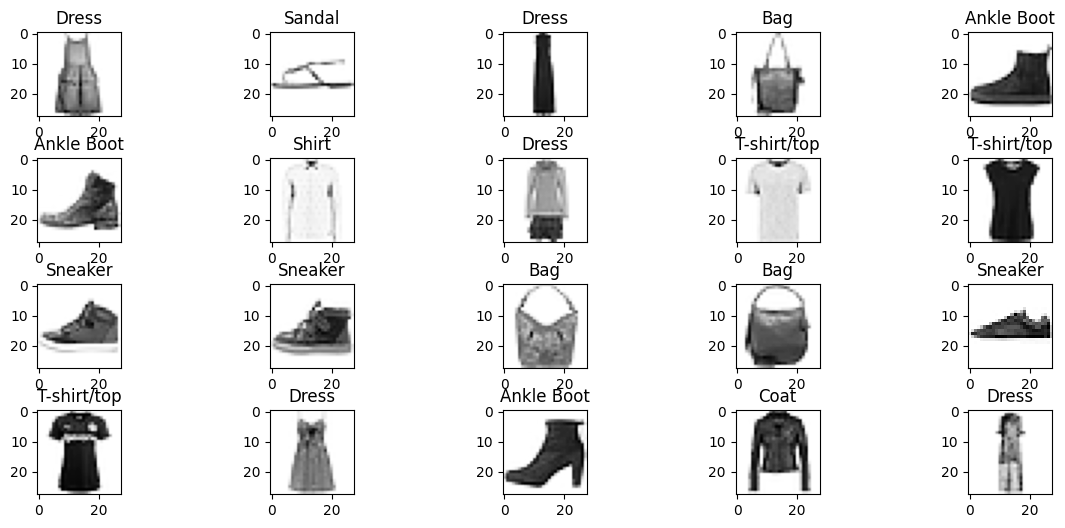

In [5]:
display_img(train_data)

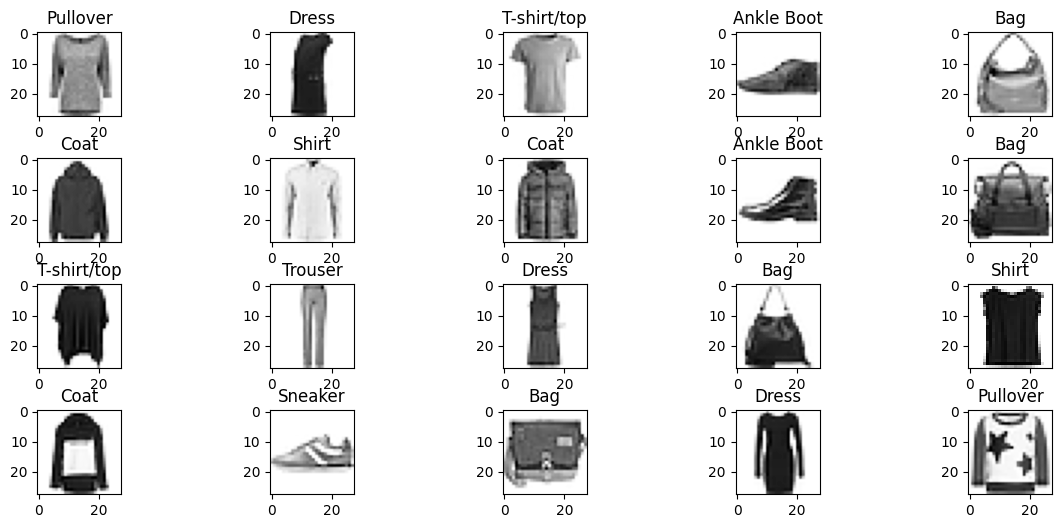

In [6]:
display_img(test_data)

## RANDOM FOREST CLASSIFIER FOR THE DATASET WITHOUT PCA

Scaling the data by total number of possible pixel values of 255.0, this will ensure that our gradients are stable while using neural networks. Else the gradients may overflow due to high input values.

In [4]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

## RUNNING THE RANDOM FOREST ALGORITHM WITH DEFAULT PARAMETERS BEFORE DOING PCA. HERE `X_train` IS WITHOUT DIMENSIONALITY REDUCTION

In [5]:
start = time.time()
rf_model = RandomForestClassifier(n_jobs=-1,random_state=42)

rf_model.fit(X_train,y_train)
print(f"It took {round(time.time()-start,3)} seconds")

It took 11.24 seconds


In [6]:
print("Validation accuracy of RF Model: ",rf_model.score(X_val,y_val))
print("Test accuracy of RF Model: ",rf_model.score(X_test,y_test))

Validation accuracy of RF Model:  0.8765
Test accuracy of RF Model:  0.8835


## APPLYING PCA

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_scaled = pca.fit_transform(X_train)

In [6]:
plt.style.use('ggplot')
explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

## 95% EXPLAINED VARIANCE

## Q1: Getting the required number of PCA components that explain 95% of the variance. So we need `187` components from `784` components to explain `95%` of the variance


In [7]:
req_comp = np.where(cum_var>=0.95)[0][0] + 1
print(f"The number of required PCA components: ",req_comp)

The number of required PCA components:  187


Text(0, 0.5, 'Cumulative Explained Variance')

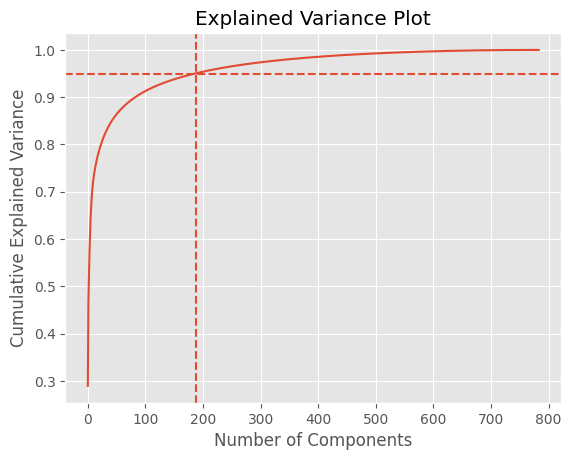

In [9]:
plt.style.use("ggplot")
plt.plot(cum_var)
plt.axhline(0.95,linestyle='--')
plt.axvline(req_comp,linestyle='--')
plt.title("Explained Variance Plot")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

## FITTING WITH THE TRAIN SET WITH 95% EXPLAINED VARIANCE

In [8]:
pca_trans = PCA(n_components=req_comp)

X_train_scaled = pca_trans.fit_transform(X_train)
X_val_scaled = pca_trans.transform(X_val)
X_test_scaled = pca_trans.transform(X_test)

In [9]:
#INVERSE TRANSFORM
X_recovered_train = pca_trans.inverse_transform(X_train_scaled)
X_recovered_val = pca_trans.inverse_transform(X_val_scaled)

## Q3: PLOTTING IMAGES WITH AND WITHOUT PCA FOR COMPARISON

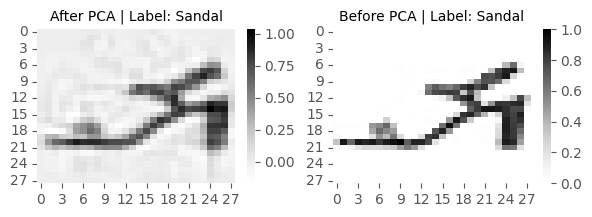

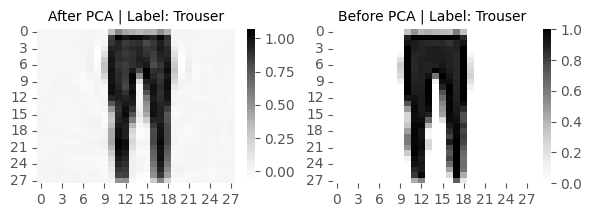

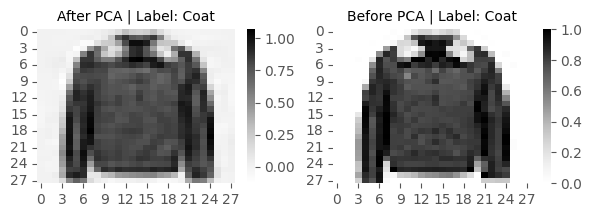

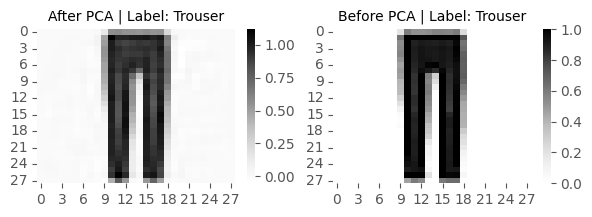

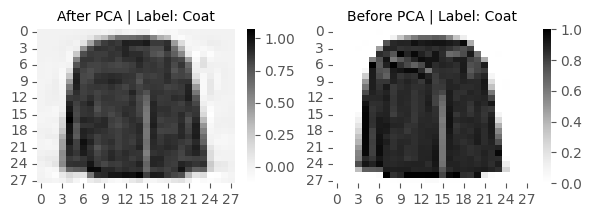

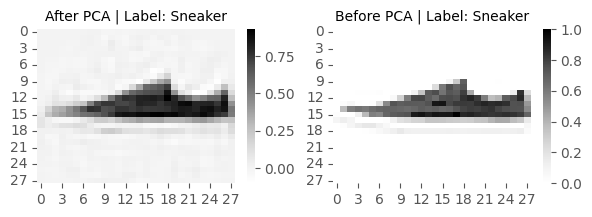

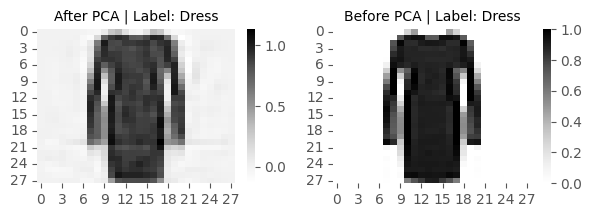

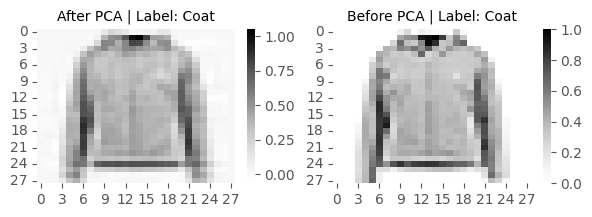

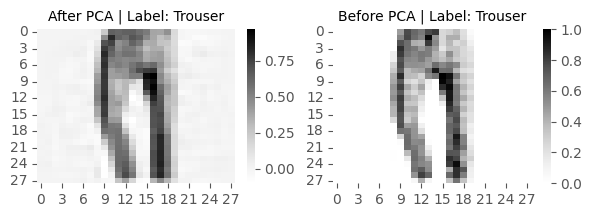

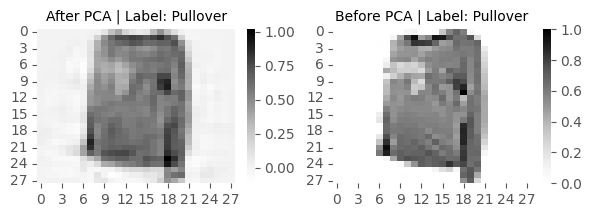

In [49]:
random_idxs = np.random.randint(low=0,high=len(X_train),size=10)

for idx in random_idxs:
    fig, axs = plt.subplots(1, 2, figsize=(7, 2))
    sns.heatmap(X_train.loc[idx].values.reshape(28,28),ax=axs[1],cmap='Greys')
    sns.heatmap(X_recovered_train[idx].reshape(28,28),ax=axs[0],cmap='Greys')
    axs[0].set_title(f"After PCA | Label: {y_cols[y_train[idx]]}",fontsize=10)
    axs[1].set_title(f"Before PCA | Label: {y_cols[y_train[idx]]}",fontsize=10)

In [12]:
start = time.time()
pca_rf_model = RandomForestClassifier(n_jobs=-1,random_state=42)
pca_rf_model.fit(X_train_scaled,y_train)
print(f"It took {round(time.time()-start,2)} seconds")

It took 14.6 seconds


In [13]:
print("Validation accuracy of RF Model: ",pca_rf_model.score(X_val_scaled,y_val))
print("Test accuracy of RF Model: ",pca_rf_model.score(X_test_scaled,y_test))

Validation accuracy of RF Model:  0.8595
Test accuracy of RF Model:  0.862


| Model           | Val Accuracy Score  | Test Accuracy Score | Time taken(s) |
| ----------------|---------------------|----------------------|------- |
| RF WITHOUT PCA     |    0.8765              | 0.8835                |11.24
| RF WITH PCA  | 0.8595                 |0.862                 |14.6

# Q2: OBSERVATIONS
* RF forest algorithm without PCA took less time as compared to RF with PCA. This is counterintuitive as dimensionality reduction `784` to `187` increases the fitting time. But Random forest exploits the variation among the data to build decision trees and data with higher covariance facilitates building decision trees, as we can split easily. But PCA reduces the variation among the data and very low covariance. This makes the decision tree split harder, thus the decision trees needs to be wider and have higher depth, which increases the fitting time
* Also, the accuracy of RF with PCA is lower than without PCA algorithm, because we have components that explain only `95%` of variance. But the accuracy only takes a marginal hit, but dimensionality reduction sometimes is not effective for random forests as it exploits these covariances to build trees. 

## EXPLAINED VARIANCE FROM FIRST TWO COMPONENTS

## PCA PLOTS

In [12]:
pca_2d = PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(X_train)

## Q4 EXPLAINED VARIANCE FROM ONLY TWO COMPONENTS

In [15]:
comps = 2
print(f"Variance explained by first two {comps} is {round(sum(pca_2d.explained_variance_ratio_),3)} ")

Variance explained by first two 2 is 0.467 


## Q5: PLOTTING `1000` IMAGES AFTER DIMENSIONALITY REDUCTION USING PCA, T-SNE, LLE AND MDS

In [16]:
import random
num_images = 1000

comb_list = list(zip(X_train_2d,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot = [td for (td,l) in selected_list]
y_2d_plot = [l for (td,l) in selected_list]

In [17]:
X_2d_plot = np.array(X_2d_plot)
y_2d_plot = np.array(y_2d_plot)

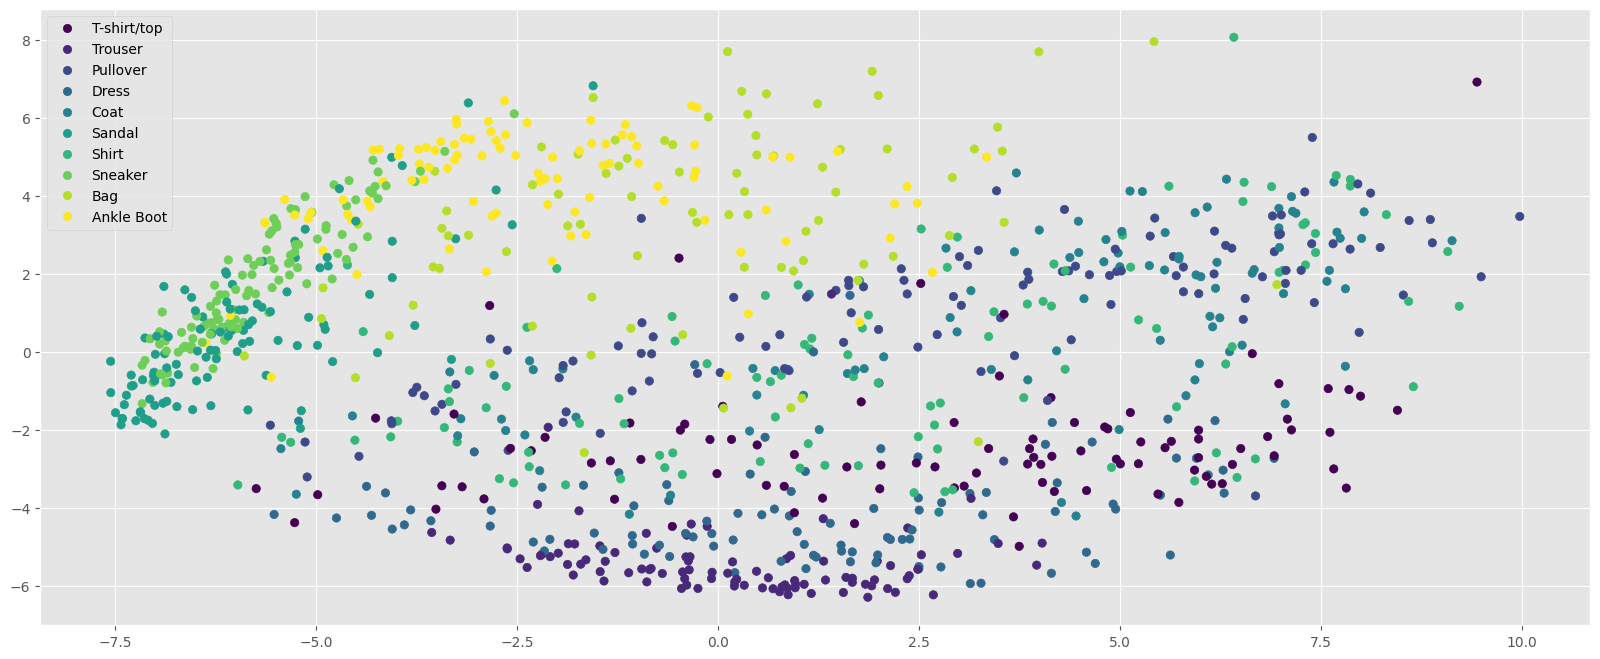

In [62]:
#Plotting only first two components of PCA
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot[:,0],X_2d_plot[:,1],c=y_2d_plot,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

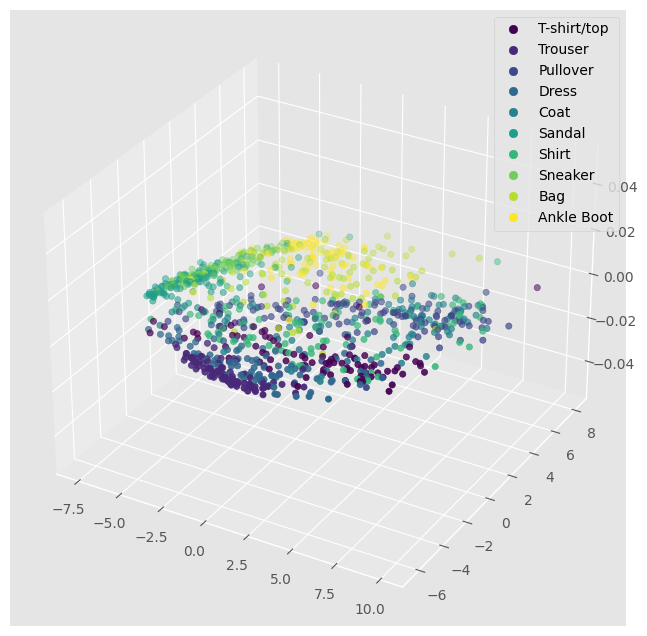

In [60]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
axs = ax.scatter(X_2d_plot[:,0],X_2d_plot[:,1],c=y_2d_plot,label=y_cols)
plt.legend(handles=axs.legend_elements()[0], labels=y_cols)

The PCA plot is not able to capture all the variations in the data. As we saw earlier, the first two components can only capture `0.467` of the cumulative variance. So the clusters are not segregated properly in PCA

## T-SNE

In [77]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=50)

X_tsne = tsne.fit_transform(X_train)

/home/athekunal/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/athekunal/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
import numpy as np

with open('TSNE.npy', 'wb') as f:
    np.save(f, X_tsne,allow_pickle=True)

with open('TSNE.npy', 'rb') as f:
    X_tsne = np.load(f,allow_pickle=True)

In [16]:
num_images = 1000

comb_list = list(zip(X_tsne,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_tsne = [td for (td,l) in selected_list]
y_2d_plot_tsne = [l for (td,l) in selected_list]

In [17]:
X_2d_plot_tsne = np.array(X_2d_plot_tsne)
y_2d_plot_tsne = np.array(y_2d_plot_tsne)

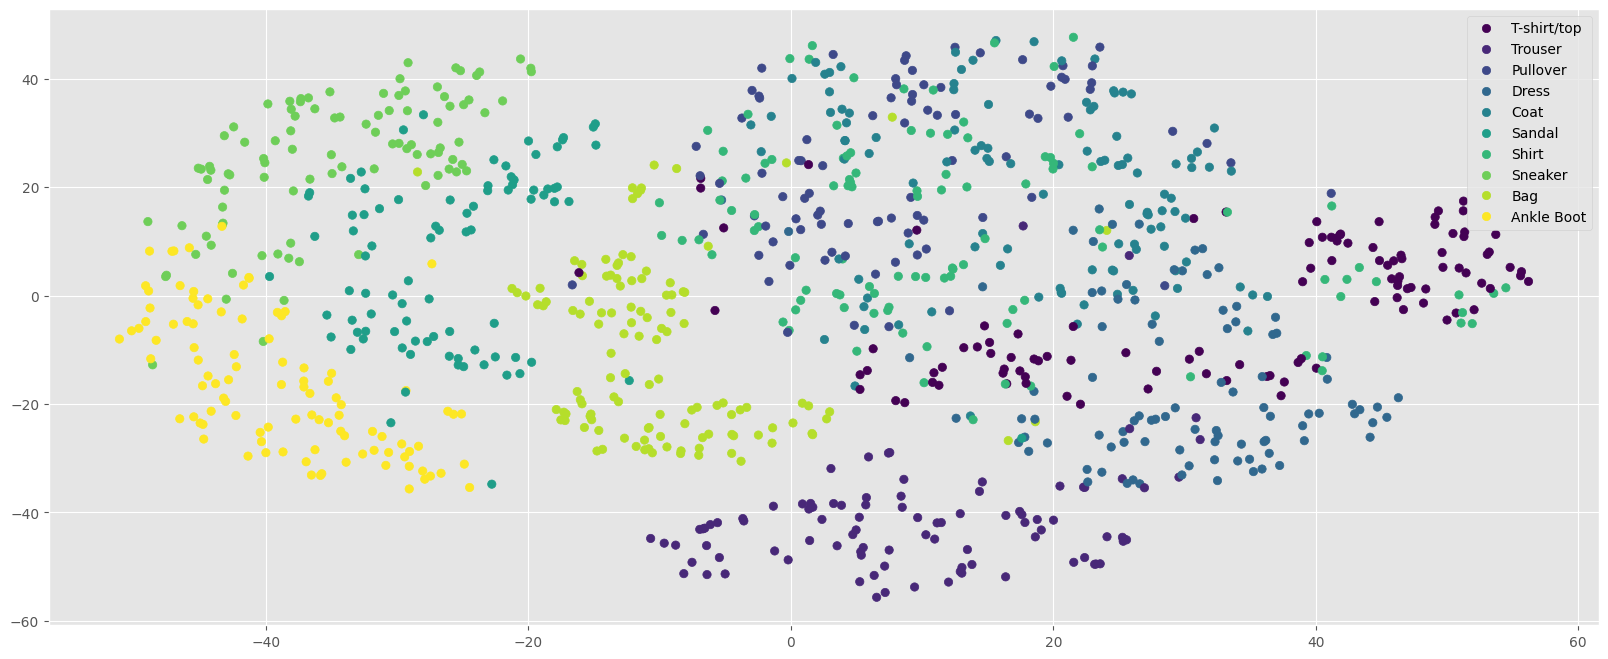

In [18]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot_tsne[:,0],X_2d_plot_tsne[:,1],c=y_2d_plot_tsne,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

Text(0.5, 0.92, 'T-SNE')

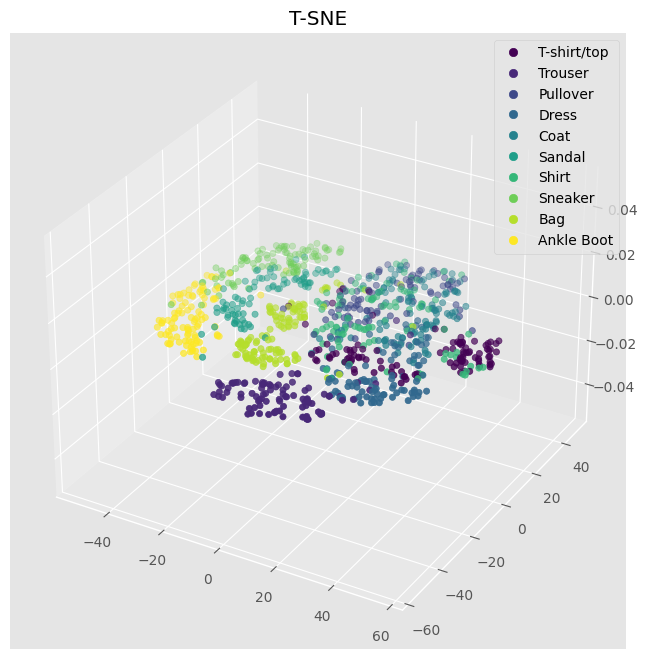

In [20]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
axs = ax.scatter(X_2d_plot_tsne[:,0],X_2d_plot_tsne[:,1],c=y_2d_plot_tsne,label=y_cols)
plt.legend(handles=axs.legend_elements()[0], labels=y_cols)
plt.title("T-SNE")

T-SNE does a good job of separating the clusters. The `perplexity` parameter in T-SNE is a hyperparameter, if we increase the clusters become more dense as it increases attracting force among the similar points and increases replusive force among disimliar points. So we have set a value of 50 to visualize the cluster

## LLE

In [88]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_jobs=-1)

X_lle = lle.fit_transform(X_train)

In [21]:
import numpy as np

with open('LLE.npy', 'wb') as f:
    np.save(f, X_lle,allow_pickle=True)

with open('LLE.npy', 'rb') as f:
    X_lle = np.load(f,allow_pickle=True)

In [22]:
num_images = 1000

comb_list = list(zip(X_lle,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_lle = [td for (td,l) in selected_list]
y_2d_plot_lle = [l for (td,l) in selected_list]

X_2d_plot_lle = np.array(X_2d_plot_lle)
y_2d_plot_lle = np.array(y_2d_plot_lle)

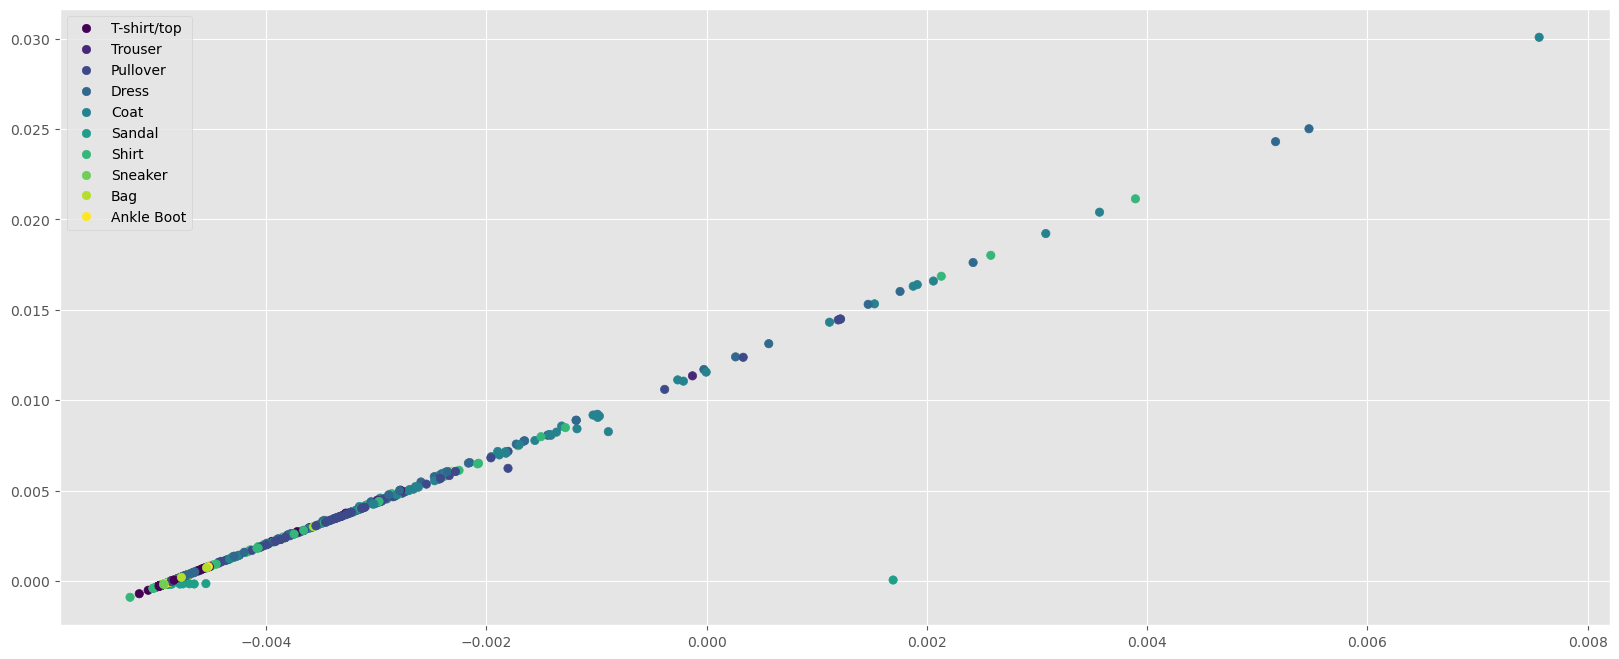

In [26]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot_lle[:,0],X_2d_plot_lle[:,1],c=y_2d_plot_lle,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

## MDS

## Fitting MDS with only `5000` images as it is memory intensive 

In [10]:
from sklearn.manifold import MDS
import random
mds = MDS()
X_mds = mds.fit_transform(X_train.sample(frac=1/10,random_state=42))

In [11]:
import numpy as np

with open('MDS.npy', 'wb') as f:
    np.save(f, X_mds,allow_pickle=True)

with open('MDS.npy', 'rb') as f:
    X_mds = np.load(f,allow_pickle=True)

In [12]:
num_images = 1000

comb_list = list(zip(X_mds.tolist(),y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_mds = [td for (td,l) in selected_list]
y_2d_plot_mds = [l for (td,l) in selected_list]

X_2d_plot_mds = np.array(X_2d_plot_mds)
y_2d_plot_mds = np.array(y_2d_plot_mds)

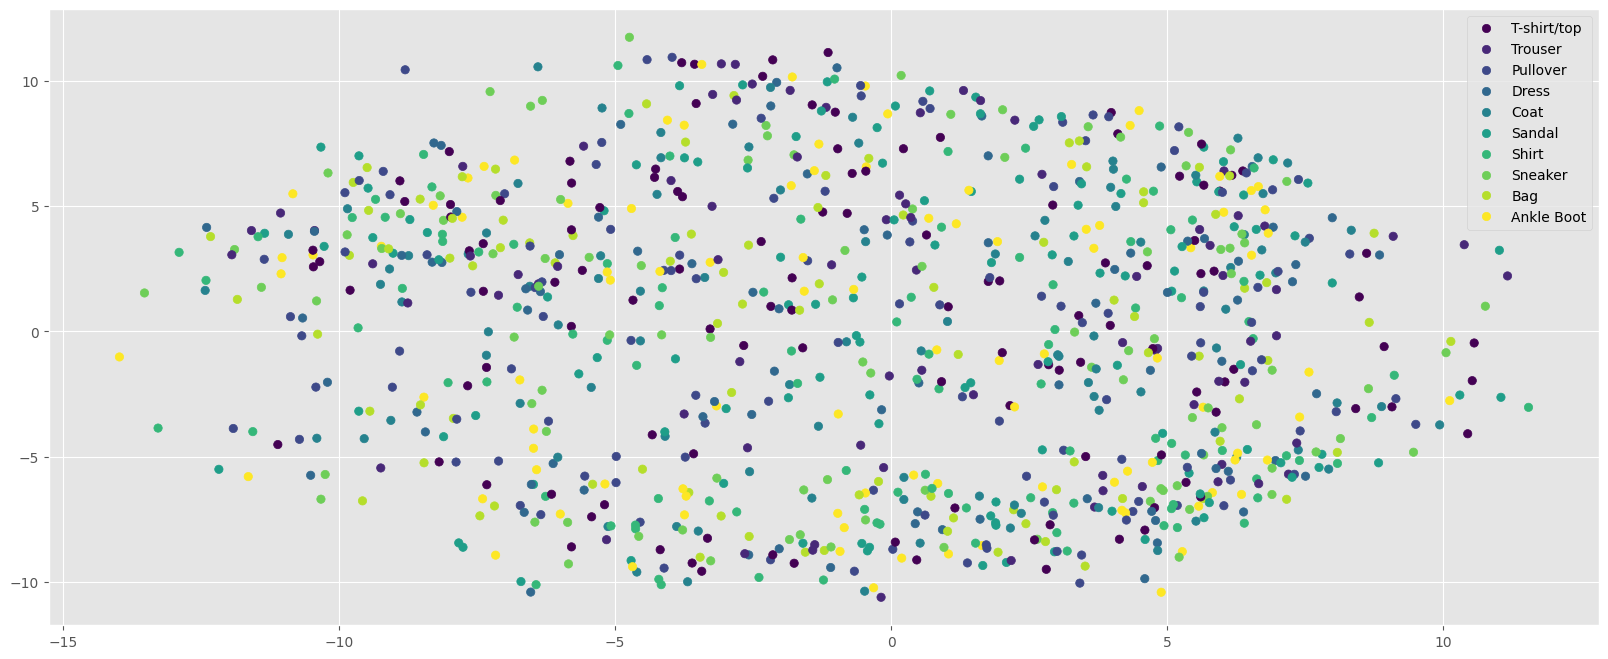

In [13]:
plt.figure(figsize=(20,8))
ax = plt.scatter(X_2d_plot_mds[:,0],X_2d_plot_mds[:,1],c=y_2d_plot_mds,label=y_cols)
plt.legend(handles=ax.legend_elements()[0], labels=y_cols)

##

## Q-5
Based on the problem statement of visualizing clusters of similar clothing items in the MNIST Fashion dataset, t-SNE would likely be the most appropriate technique to use. This is because t-SNE is particularly effective at preserving the local structure of the data, which is useful for identifying clusters of similar items. In T-SNE we can see similar clusters forming a dense structure. 
Additionally, t-SNE is a popular technique for visualizing and clustering high-dimensional data, such as images, and has been shown to be effective in identifying patterns and relationships between data points. It captures the local relationship in the high dimensional space and tries to reproduce those weighted relation in a 2-d space. In images, we have some overlap between similar images and also dissimilar images. So these local relationships are essential to represent in lower dimension. Hence T-SNE does it well. PCA captures the linear relationship as we are not using KernelPCA here, and it fails to capture the non-linear relationship. Also, MDS is a linear technique hence it has those smae disadvantages as PCA. LLE is a nonlinear method but it does not capture the local relationships.

## KMeans

In [18]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
train = pd.concat([X_train_scaled_df,y_train],axis=1)

sample_data = train.groupby('label').apply(lambda x:x.sample(frac=1/5)).reset_index(drop=True)

In [19]:
sample_data['label'].value_counts(normalize=True)

0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

In [20]:
sample_data = sample_data.sample(frac=1)
X_kmeans_train = sample_data[sample_data.columns[:-1]]
y_kmeans_train = sample_data['label']

In [22]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

In [16]:
num_clusters = [i for i in range(5,51)]

kmeans_dicts = {}
for clusters in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=clusters,random_state=42)
    kmeans.fit(X_kmeans_train)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_kmeans_train, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_kmeans_train, cluster_labels)
    kmeans_dicts.update({str(clusters):[kmeans.inertia_,silhouette_avg,sample_silhouette_values]})

100%|██████████| 46/46 [06:04<00:00,  7.92s/it]


In [17]:
import pickle 

with open('KMeans.pkl', 'wb') as f:
    pickle.dump(kmeans_dicts, f)
        
with open('KMeans.pkl', 'rb') as f:
    kmeans_dicts = pickle.load(f)

In [18]:
inertia_vals = [val[0] for val in kmeans_dicts.values()]
silhoutte_coeffs = [val[1] for val in kmeans_dicts.values()]

Text(0.5, 1.0, 'Inertia Values vs. Number of Centroids')

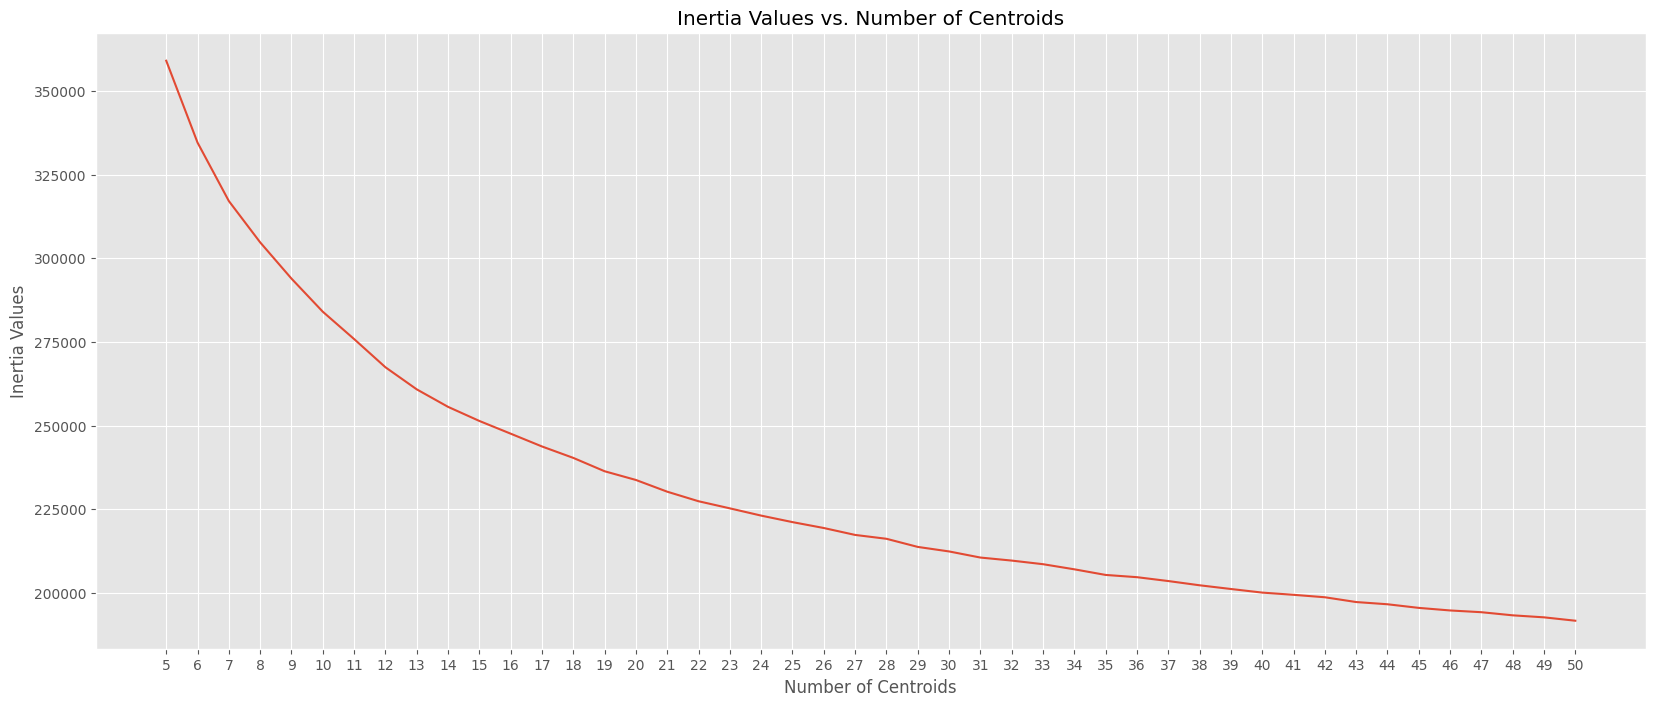

In [19]:
num_clusters = [str(i) for i in num_clusters]
plt.figure(figsize=(20,8))
plt.plot(num_clusters,inertia_vals)
plt.xlabel("Number of Centroids")
plt.ylabel("Inertia Values")
plt.title("Inertia Values vs. Number of Centroids")

Text(0.5, 1.0, 'Silhoutte Coefficients vs. Number of Centroids')

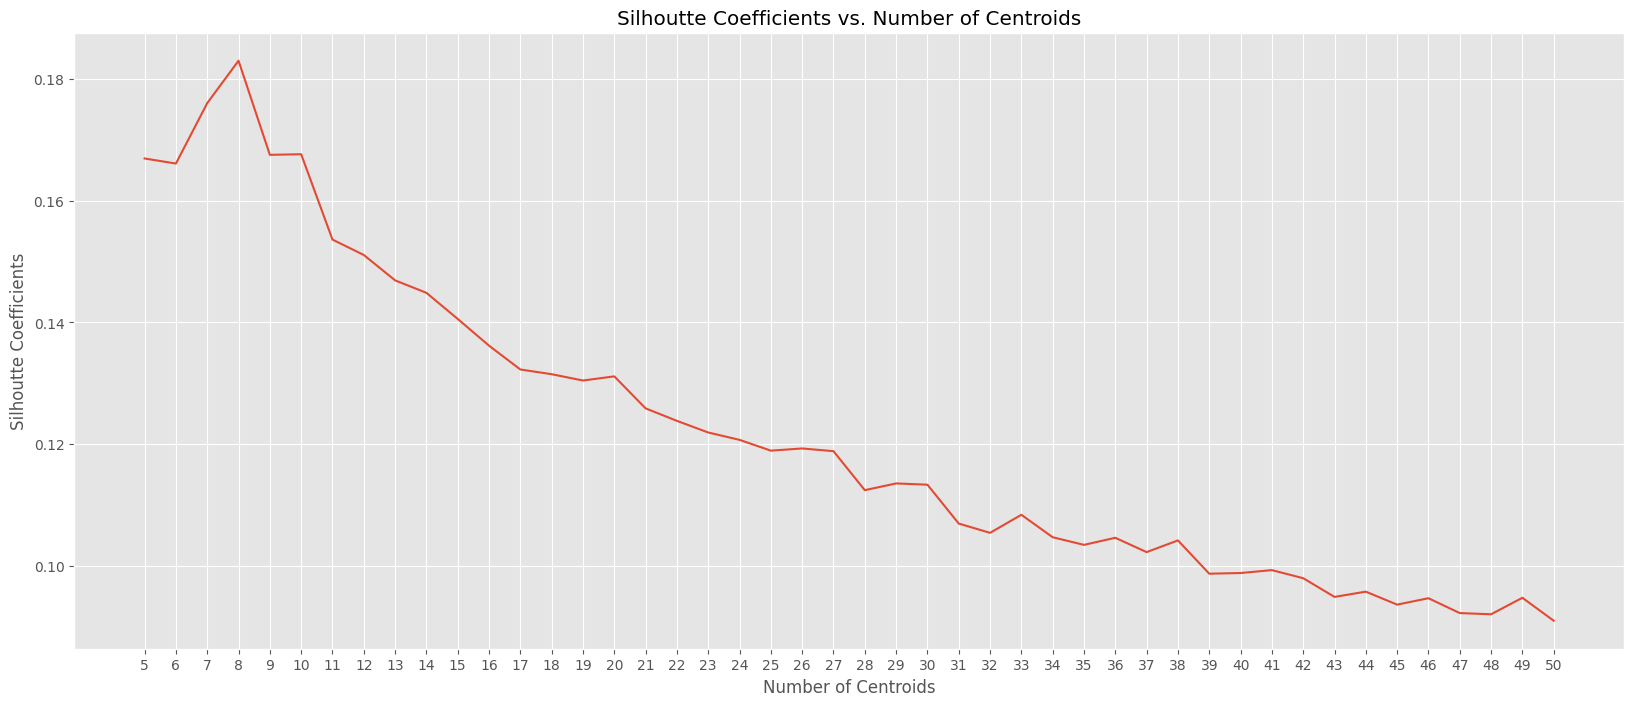

In [20]:
plt.figure(figsize=(20,8))
plt.plot(num_clusters,silhoutte_coeffs)
plt.xlabel("Number of Centroids")
plt.ylabel("Silhoutte Coefficients")
plt.title("Silhoutte Coefficients vs. Number of Centroids")

In [23]:
print(f"The best number of clusters is {5+np.argmax(silhoutte_coeffs)}")

The best number of clusters is 8


In [16]:
sample_data = train.groupby('label').apply(lambda x:x.sample(frac=1/50)).reset_index(drop=True)
sample_data = sample_data.sample(frac=1)
X_sub_kmeans_train = sample_data[sample_data.columns[:-1]]
y_sub_kmeans_train = sample_data['label']

In [17]:
import matplotlib.cm as cm

def plot_silhoutte(n_clusters:int,X):
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    clusterer.fit(X_kmeans_train)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    for idx,y in enumerate(y_cols):
        ax2 = plt.gca()
        sub_df = sample_data[sample_data.label==idx]
        sub_vals = sub_df.values
        ax2.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
   
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.legend()
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    plt.show()

For n_clusters = 9 The average silhouette_score is : 0.16657202334761684


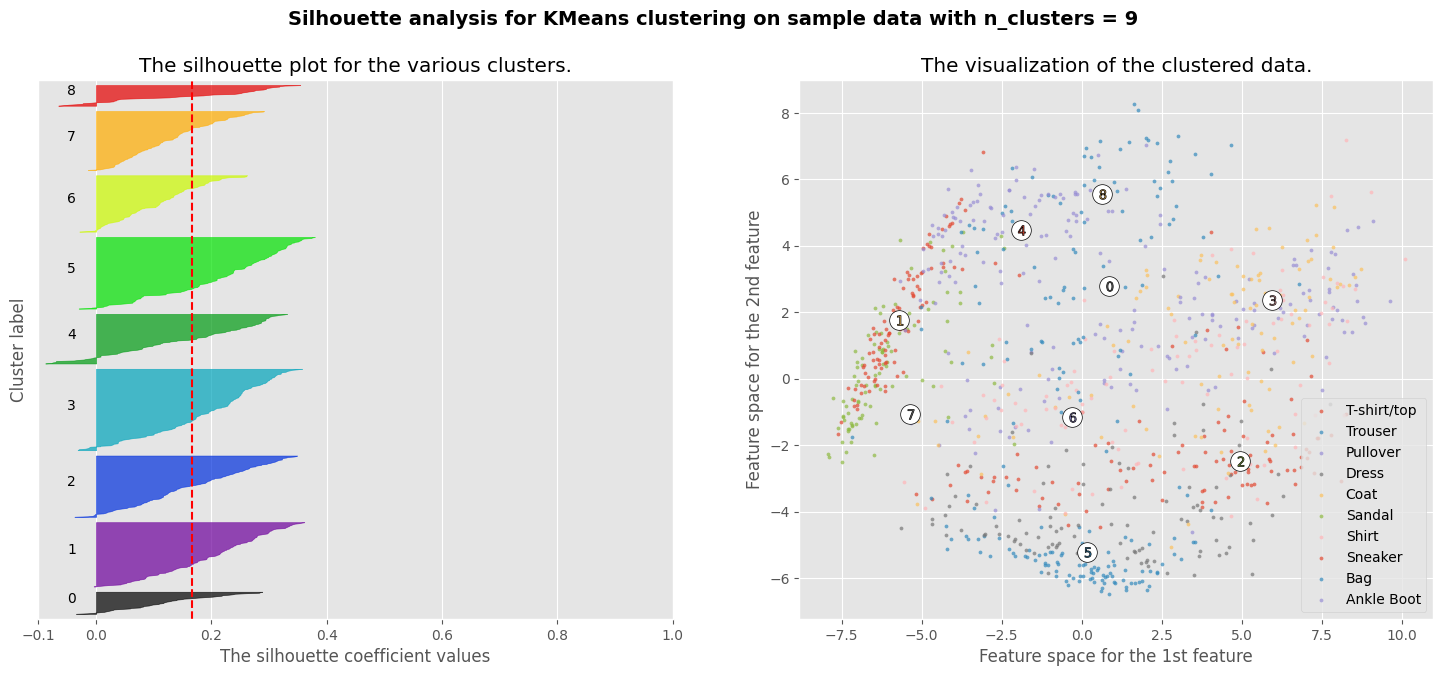

In [27]:
plot_silhoutte(9,X_sub_kmeans_train.values)

For n_clusters = 8 The average silhouette_score is : 0.16848158910756314


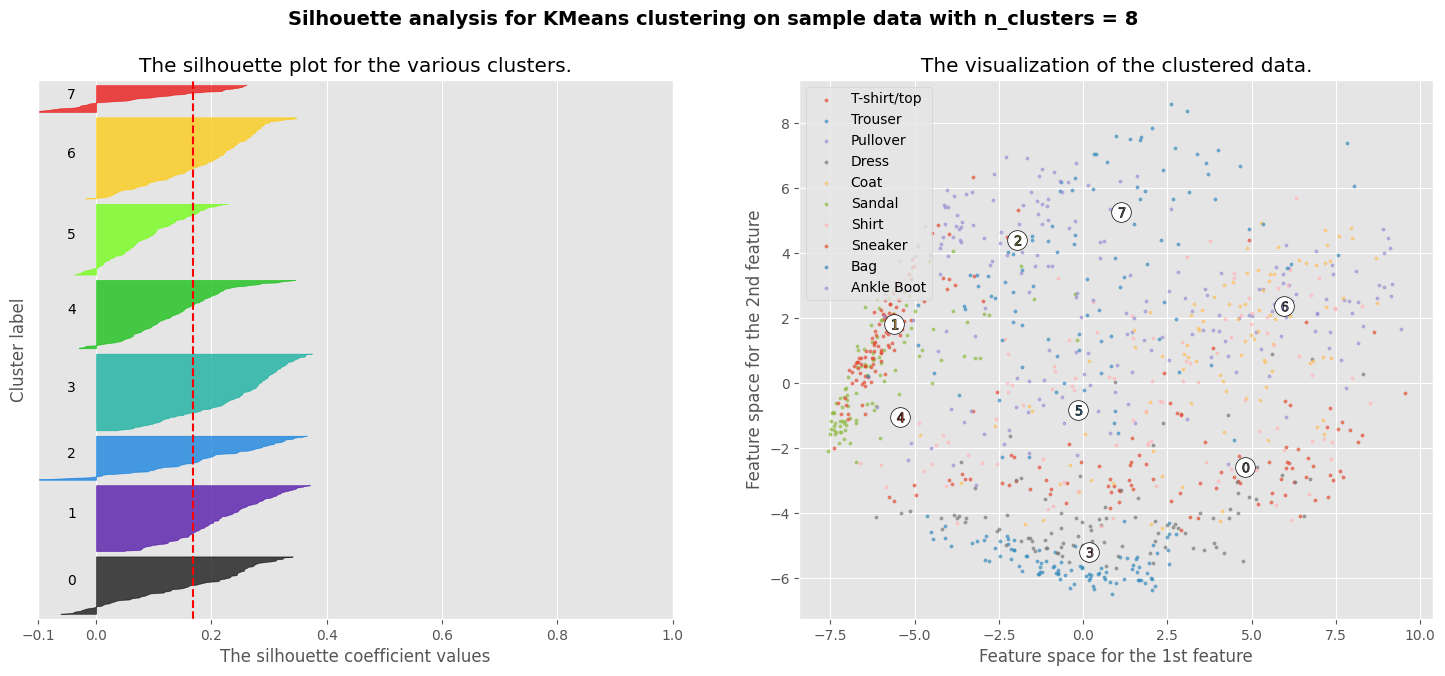

In [20]:
plot_silhoutte(8,X_sub_kmeans_train.values)

For n_clusters = 10 The average silhouette_score is : 0.1638874302049589


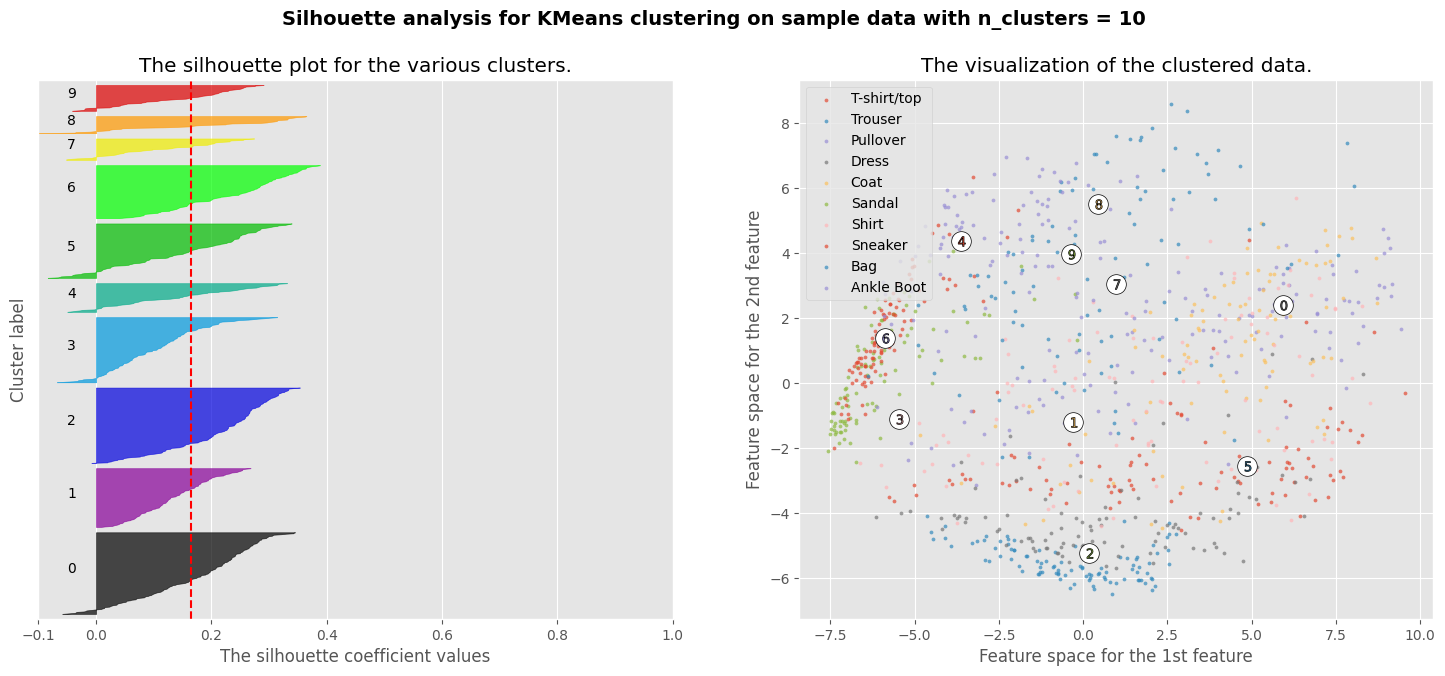

In [21]:
plot_silhoutte(10,X_sub_kmeans_train.values)

The graphs described above make it visually obvious that the ideal number of clusters appears to have a more uniform cluster width than others.

## VISUALIZE IN CLUSTERS IMAGES 

In [23]:
best_kmeans = KMeans(n_clusters=8)
best_kmeans.fit(X_kmeans_train)

cluster_labels = best_kmeans.predict(X_kmeans_train)

In [26]:
kmeans_train_df = pd.DataFrame(X_kmeans_train,columns=[i for i in range(X_train_scaled.shape[1])])
kmeans_train_df['label'] = y_kmeans_train
kmeans_train_df['kmeans_label'] = cluster_labels

Cluster 0


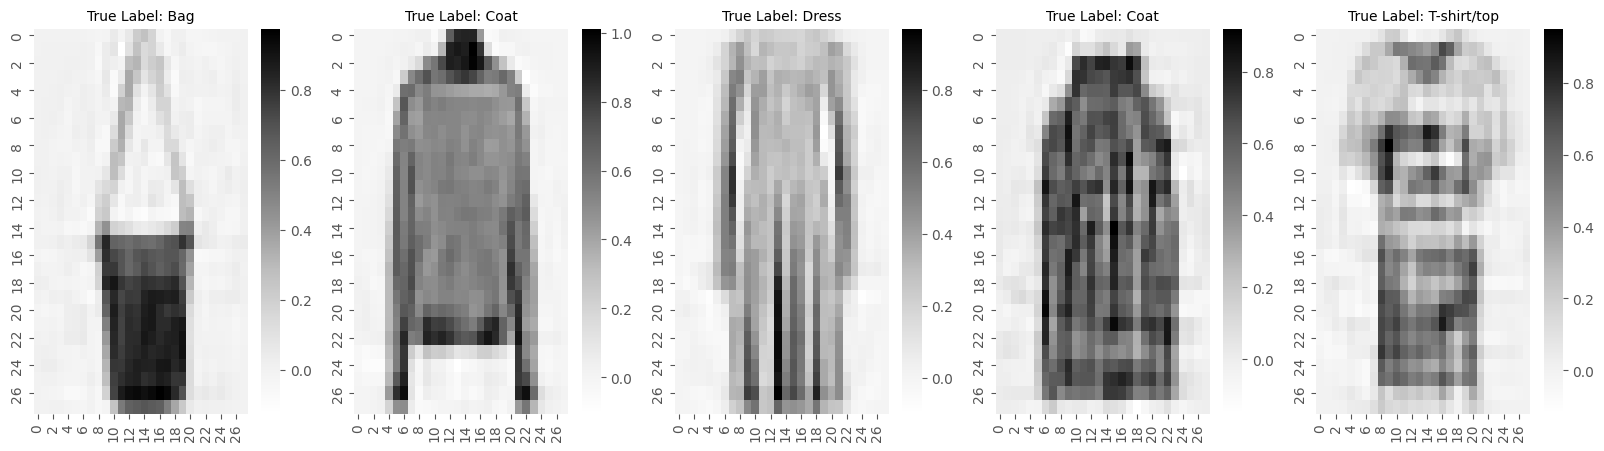

Cluster 1


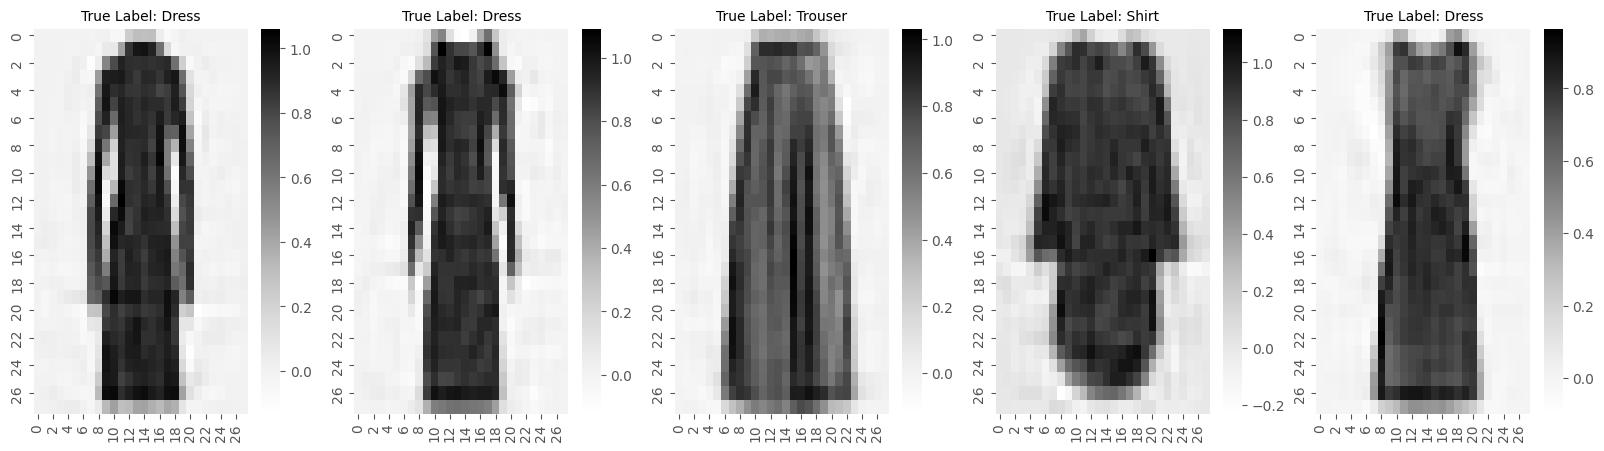

Cluster 2


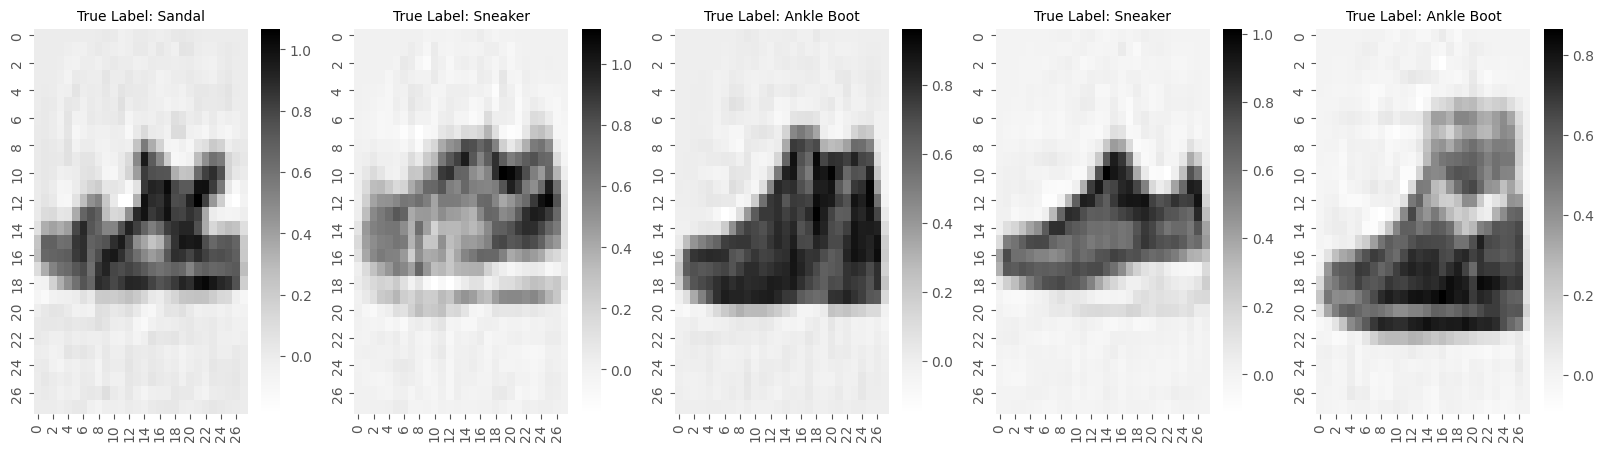

Cluster 3


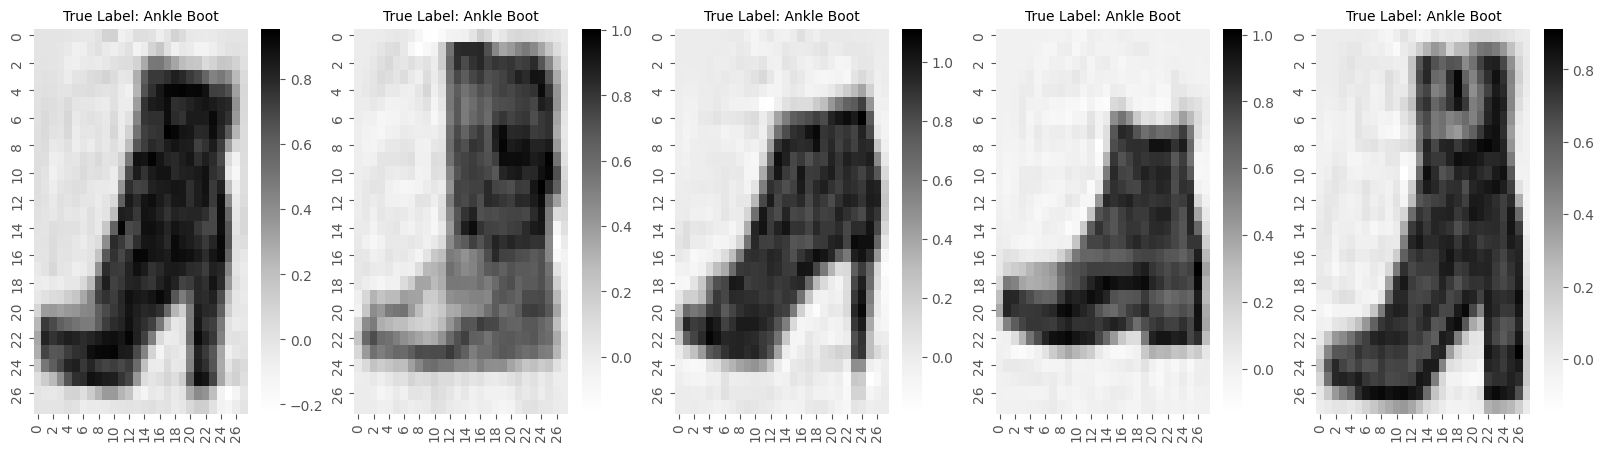

Cluster 4


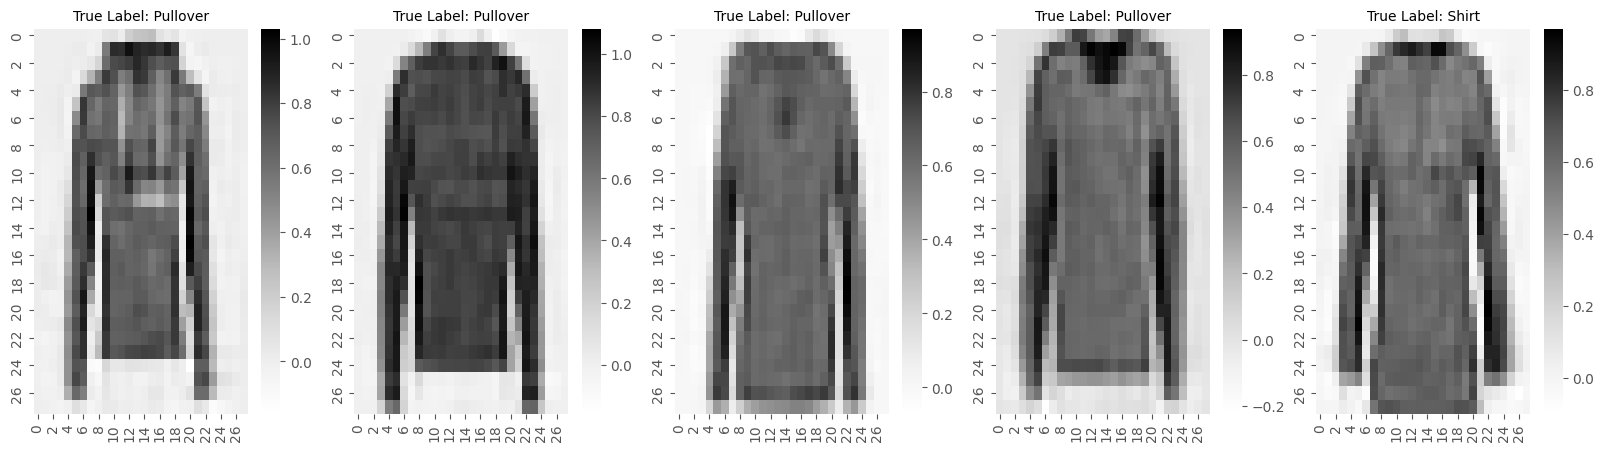

Cluster 5


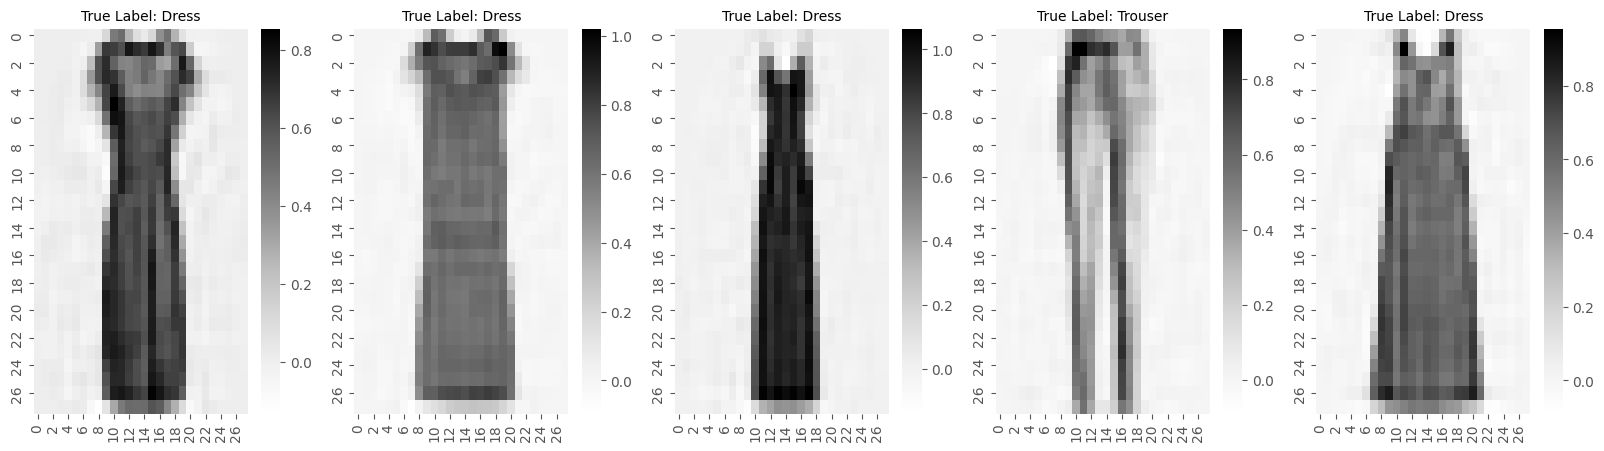

Cluster 6


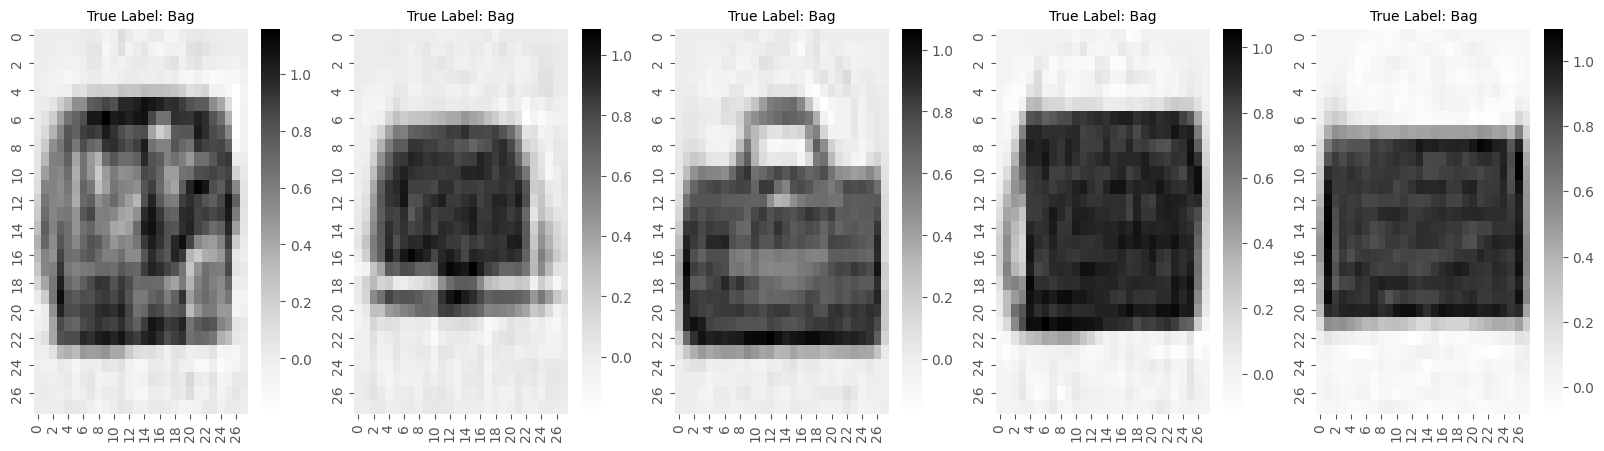

Cluster 7


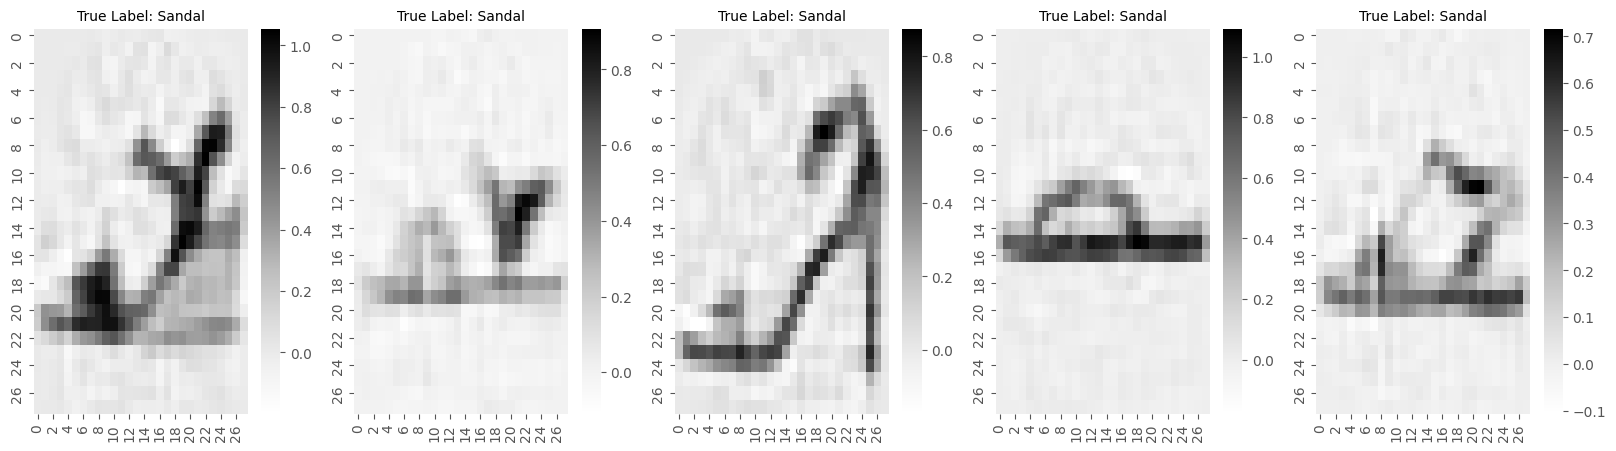

In [36]:
num_imgs = 5
for klabels in kmeans_train_df.groupby("kmeans_label"):
    klabels_ = klabels[1]
    X_vals = klabels_[klabels_.columns[:-2]].values
    X_vals = pca_trans.inverse_transform(X_vals)
    y_vals = klabels_['label'].values
    fig,ax = plt.subplots(1,num_imgs,figsize=(20,5))
    print(f"Cluster {klabels[0]}")
    for i in range(num_imgs):
        sns.heatmap(X_vals[i].reshape(28,28),cmap='Greys',ax=ax[i])
        ax[i].set_title(f"True Label: {y_cols[y_vals[i]]}",fontsize=10)
    plt.show()

Utilizing K-Means, we clustered the images after PCA has reduced the dimensionality of the Fashion MNIST dataset. Applying silhouette analysis, we established the ideal amount of clusters. Most of the cluster's clothing was comparable, as could be seen. We also noticed that it might be challenging for the algorithm to differentiate between different types of clothing that share a visual similarity, like various types of shoes, and place them in different clusters.This might be because of the algorithm's or dataset's restrictions.

## GAUSSIAN MIXTURE MODELS

In [40]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
train = pd.concat([X_train_scaled_df,y_train],axis=1)
sample_data_gmm = train.groupby('label').apply(lambda x:x.sample(frac=1/5,random_state=42)).reset_index(drop=True)
X_sub_gmm = sample_data_gmm[sample_data_gmm.columns[:-1]]
y_sub_gmm = sample_data_gmm['label']

In [38]:
from sklearn.mixture import GaussianMixture

gmm_full = GaussianMixture(n_components=10,n_init=5,covariance_type="full")
gmm_diag = GaussianMixture(n_components=10,n_init=5,covariance_type="diag")
gmm_tied = GaussianMixture(n_components=10,n_init=5,covariance_type="tied")
gmm_spherical = GaussianMixture(n_components=10,n_init=5,covariance_type="spherical")

In [28]:
def save_dictionary(name:str,dicts_):
    import pickle 

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(dicts_, f)
def read_dictionary(name:str):        
    with open(f'{name}.pkl', 'rb') as f:
        dicts_ = pickle.load(f)
    return dicts_

In [80]:
from tqdm import tqdm
def get_gaussian_mixture(k_min=5,k_max=20,covariance_type='full'):
    model_gmms = {}
    model_bics = {}
    model_aics = {}
    for n_components in tqdm(range(k_min,k_max+1)):
        gmm_model = GaussianMixture(n_components=n_components,covariance_type=covariance_type,n_init=5).fit(X_sub_gmm)
        model_gmms.update({str(n_components):gmm_model})
        model_bics.update({str(n_components):gmm_model.bic(X_sub_gmm)})
        model_aics.update({str(n_components):gmm_model.aic(X_sub_gmm)})
    plt.figure(figsize=(20,8))
    plt.plot(model_bics.keys(),model_bics.values(),label='BIC')
    plt.plot(model_aics.keys(),model_aics.values(),label='AIC')
    plt.ylabel('Information Criterion')
    plt.xlabel("Number of Clusters")
    plt.legend()
    plt.title(f'{covariance_type} GMM model')
    plt.show()
    
    plt.savefig(f'{covariance_type}.png')

    return model_gmms,model_bics,model_aics

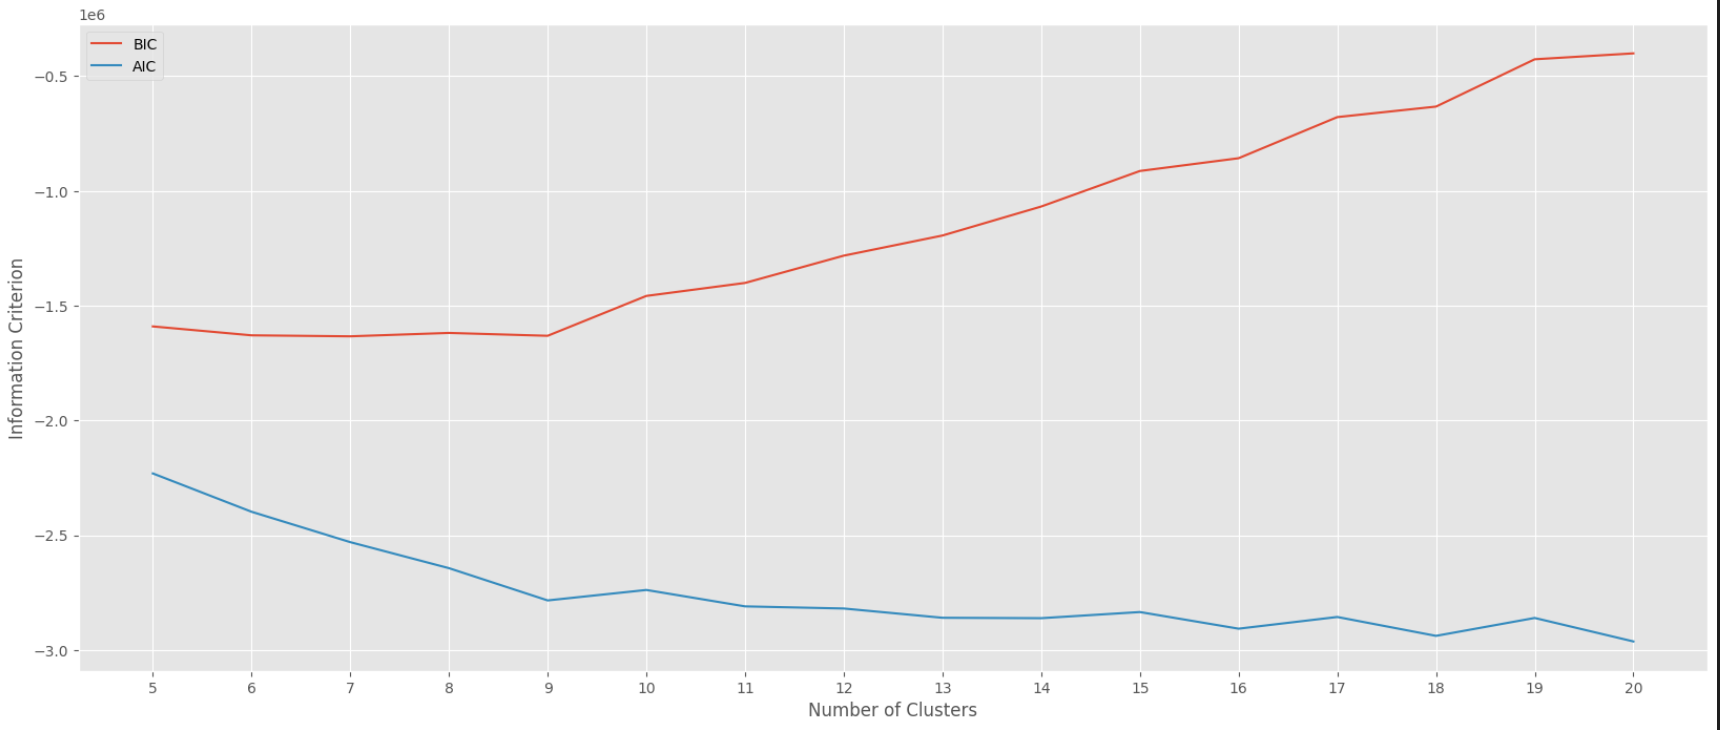

In [74]:
#This cell took around 32 minutes to run, the output was cleared during plotting
full_model_gmm,full_bic,full_aic = get_gaussian_mixture(k_min=5,k_max=20)

100%|██████████| 16/16 [01:21<00:00,  5.08s/it]


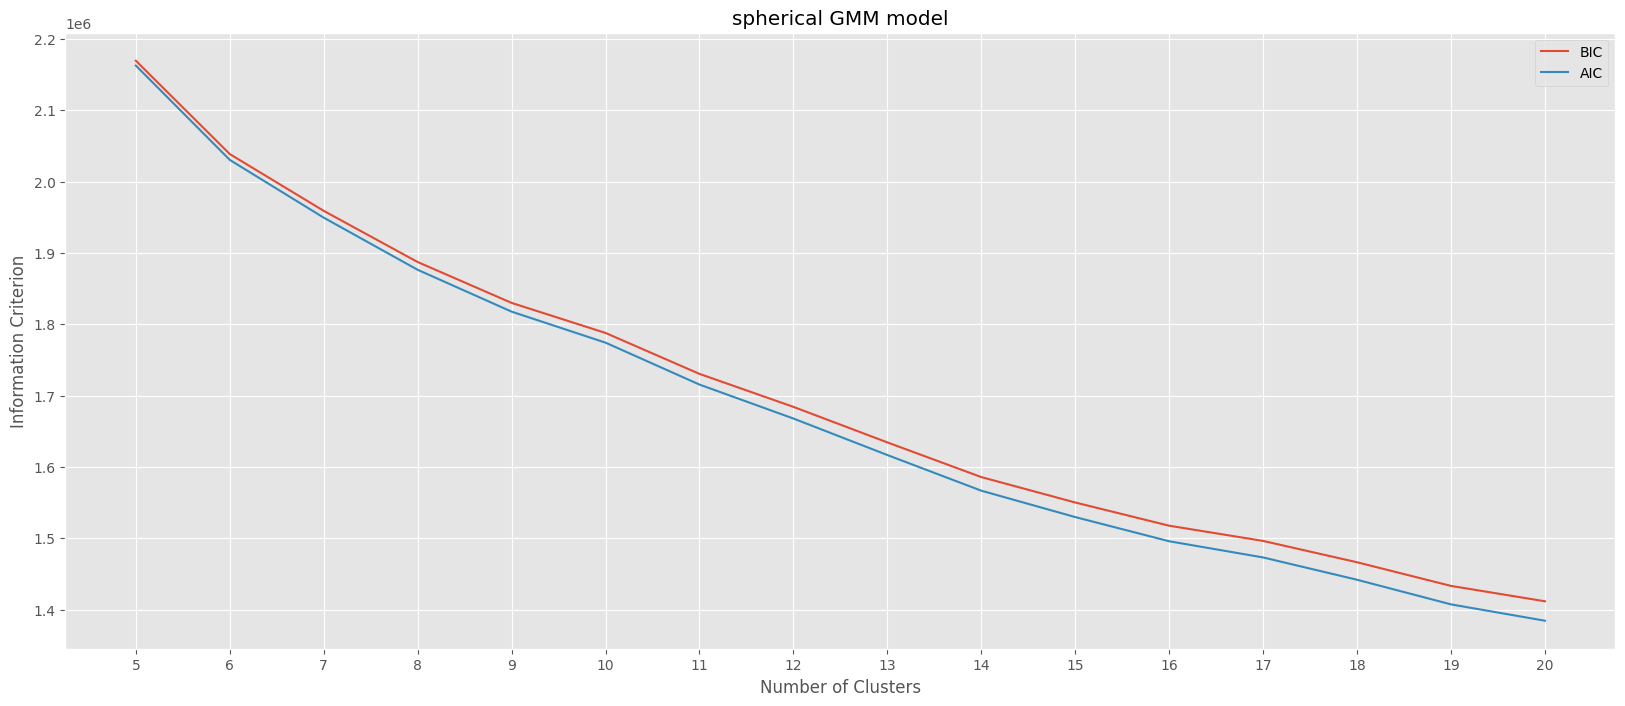

<Figure size 640x480 with 0 Axes>

In [81]:
#48 seconds
spherical_model_gmm,spherical_bic,spherical_aic = get_gaussian_mixture(k_min=5,k_max=20,covariance_type='spherical')

save_dictionary('AIC_SPHERICAL',spherical_aic)
save_dictionary('BIC_SPHERICAL',spherical_bic)

100%|██████████| 16/16 [02:08<00:00,  8.01s/it]


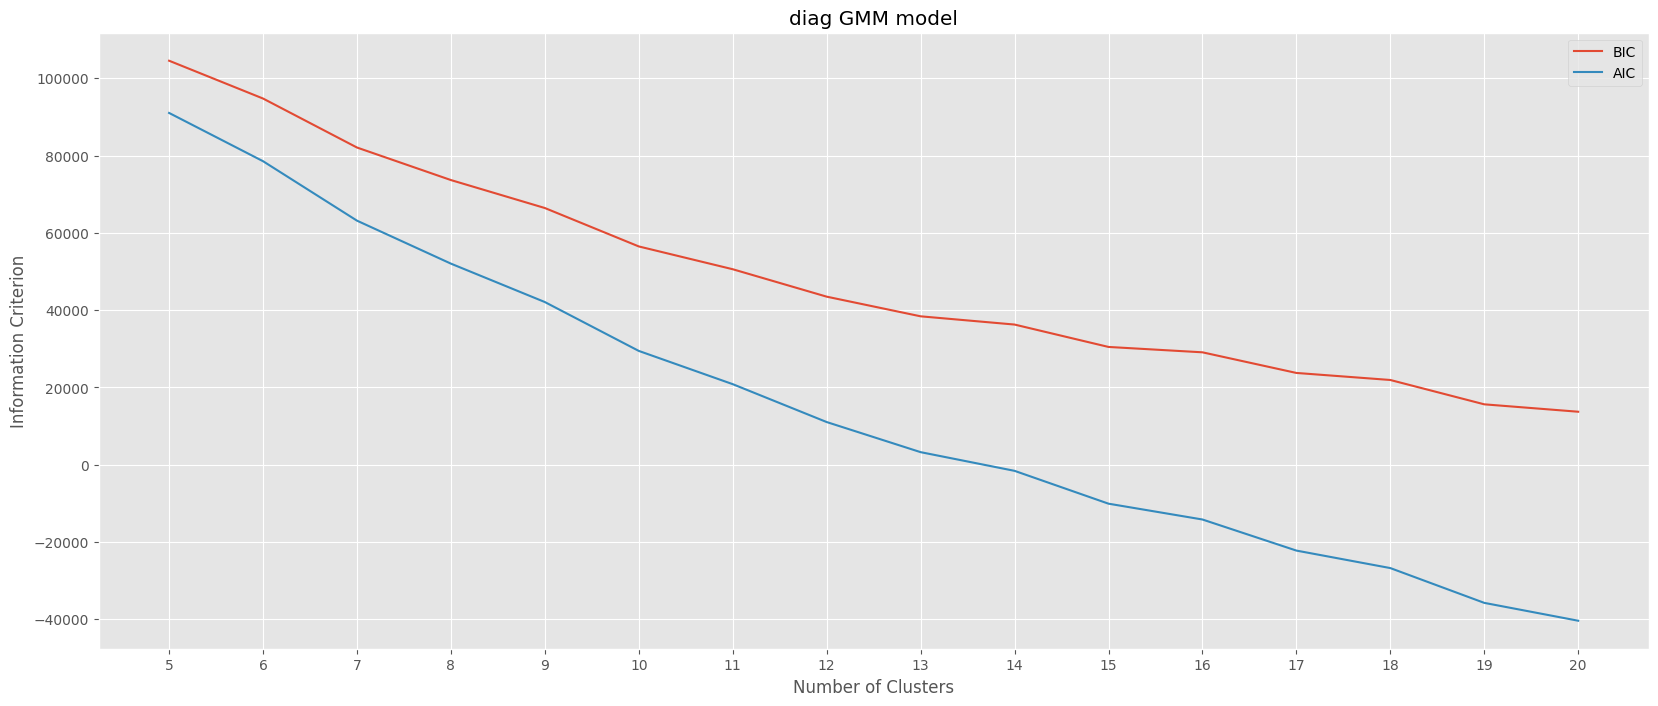

<Figure size 640x480 with 0 Axes>

In [82]:
#2 mniutes 8 seconds
diag_model_gmm,diag_bic,diag_aic = get_gaussian_mixture(k_min=5,k_max=20,covariance_type='diag')

save_dictionary('AIC_DIAG',diag_aic)
save_dictionary('BIC_DIAG',diag_bic)

100%|██████████| 16/16 [20:04<00:00, 75.31s/it] 


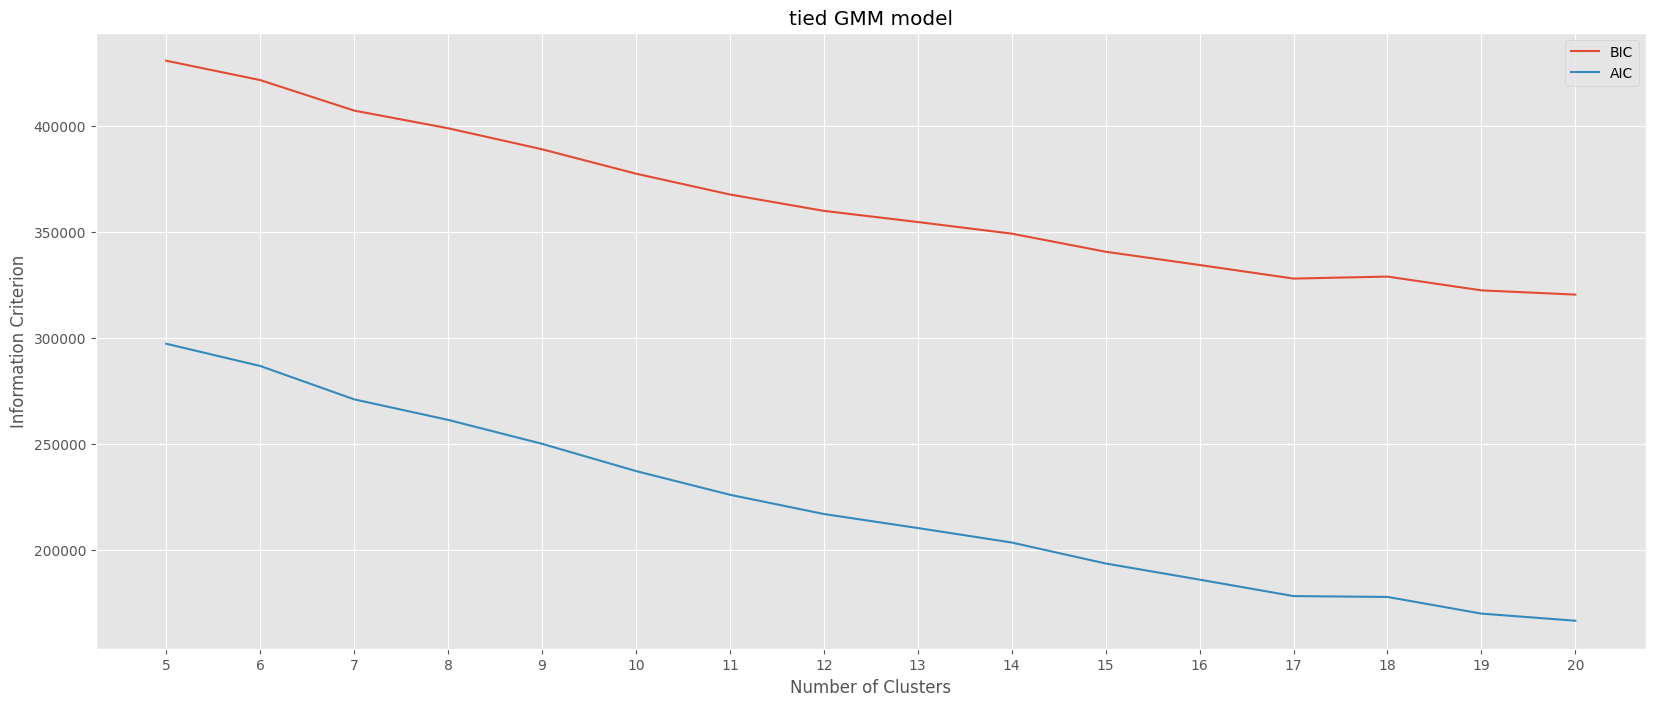

<Figure size 640x480 with 0 Axes>

In [83]:
#This cell 20 minutes
tied_model_gmm,tied_bic,tied_aic = get_gaussian_mixture(k_min=5,k_max=20,covariance_type='tied')

save_dictionary('AIC_TIED',tied_aic)
save_dictionary('BIC_TIED',tied_bic)

## Q8 AND Q9
##### THE `COVARIANCE_TYPE=FULL` GAVE THE BEST RESULTS WITH NUMBER OF `CLUSTERS=9`. WE GOT THIS BY COMPARING THE BIC OF MULTIPLE COVARIANCE TYPES AND THE RANGE OF `5-20`. WE GOT THE MINIMUM BIC FOR COVARIANCE TYPE FULL AND NUMBER OF CLUSTERS=9. 

* In full all the components have their own general covariance matrix.
* In diag all the components have their own diagonal covariance matrix.
* In tied all components share  the same general covariance matrix.
* In spherical all the components have their own spherical covariance matrix.

So full one took a loot of time to train `1920 seconds`, 
diag: `128s`
spherical: `48s`
tied: `1200s`

So the full covariance took the highest time to fit and it also gave the lowest BIC with clusters=9

##### THE `COVARIANCE_TYPE=FULL` GAVE THE BEST RESULTS WITH NUMBER OF `CLUSTERS=9`

In [41]:
best_gmm_model_full = GaussianMixture(n_components=9,n_init=5).fit(X_sub_gmm)

In [42]:
gmm_samples = best_gmm_model_full.sample(20)
X_sample,y_sample = gmm_samples

In [43]:
X_sample_recoverd = pca_trans.inverse_transform(X_sample)

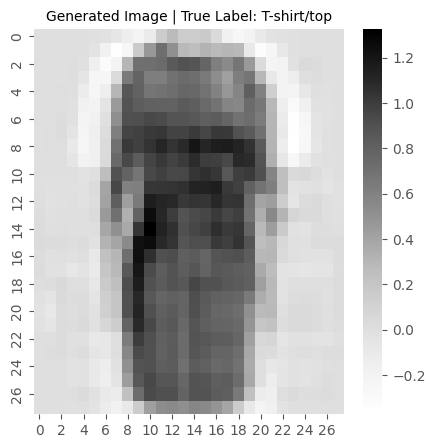

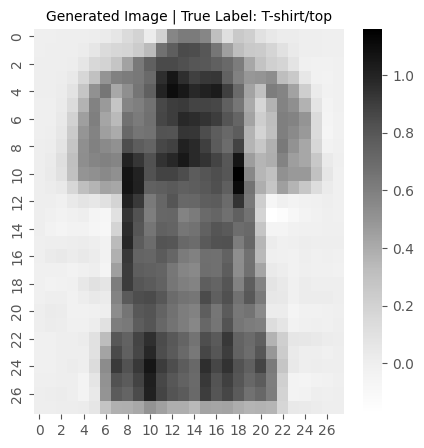

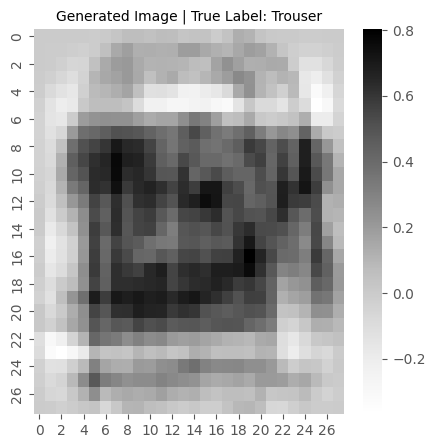

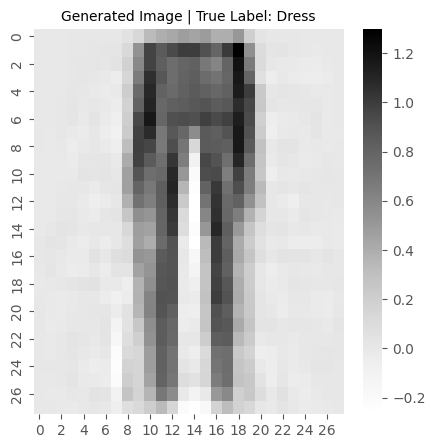

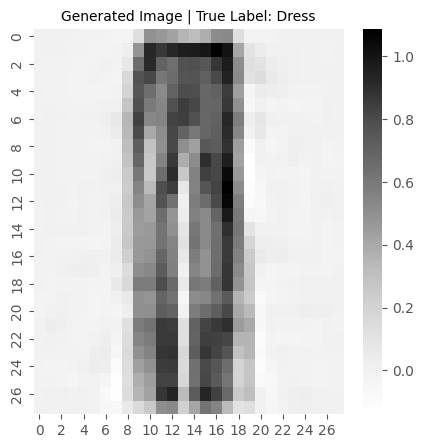

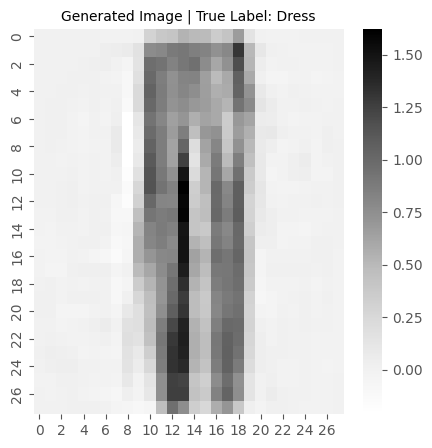

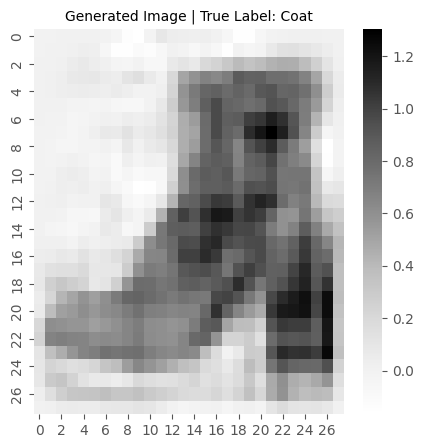

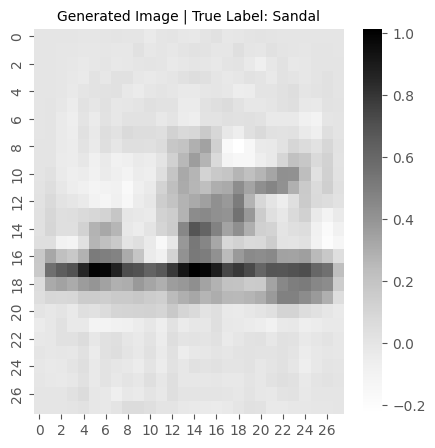

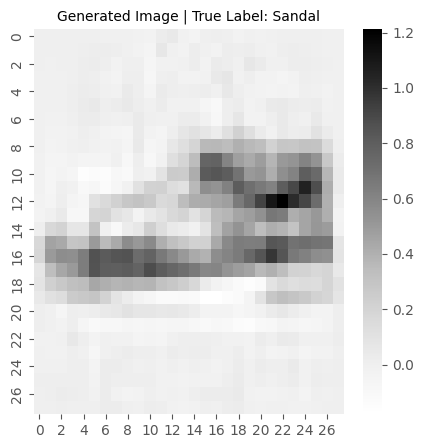

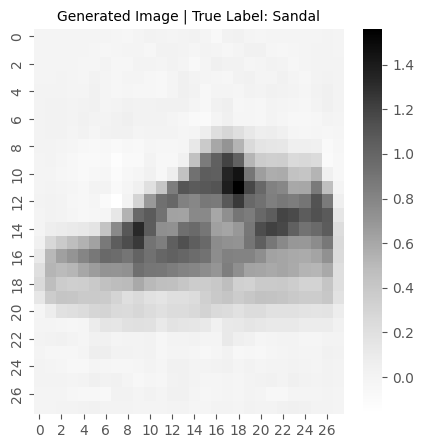

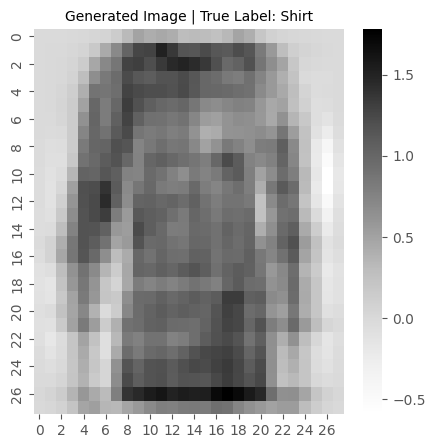

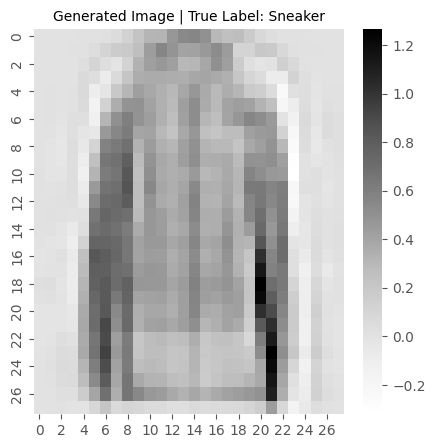

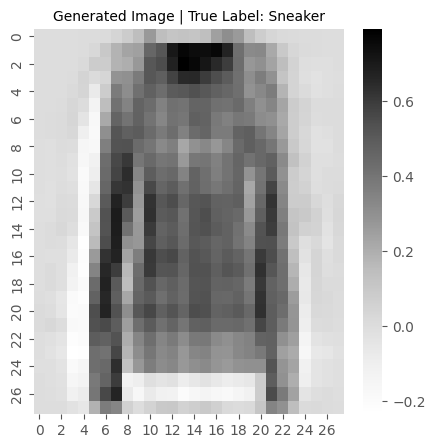

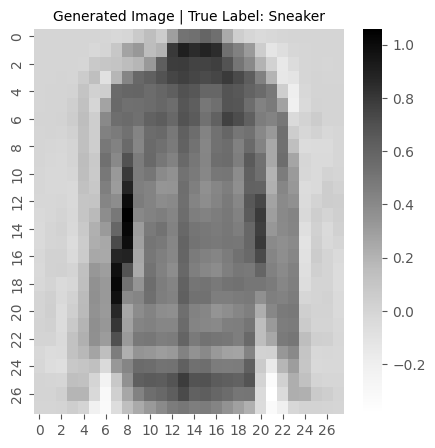

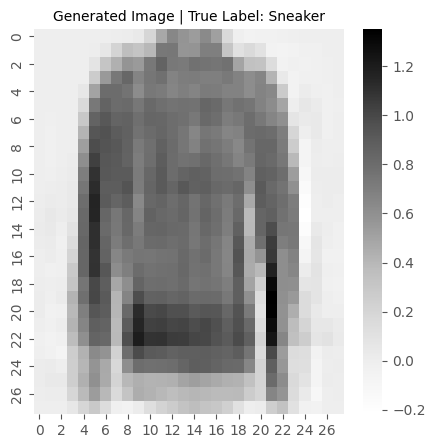

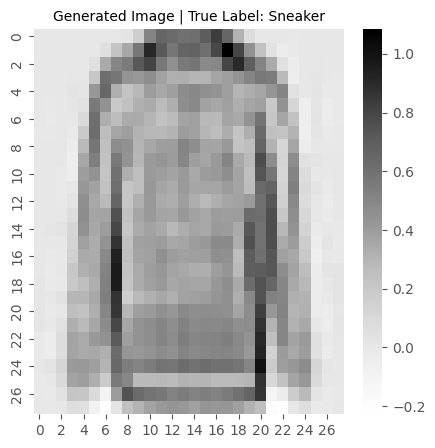

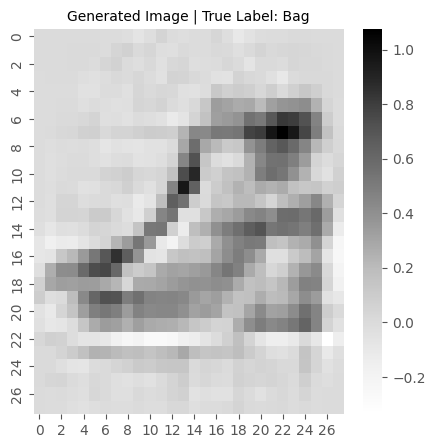

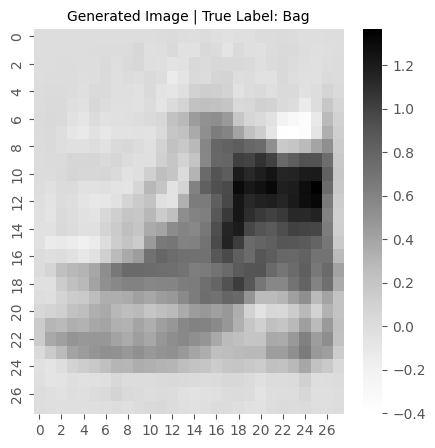

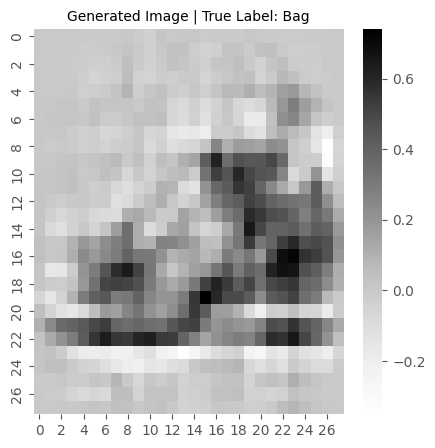

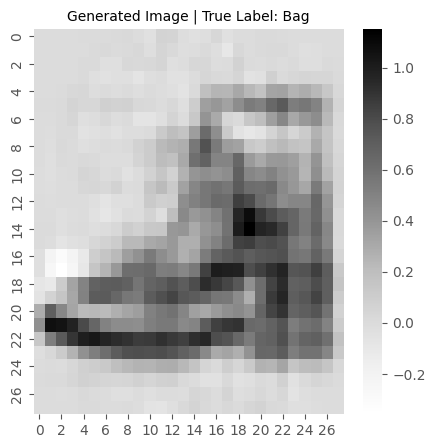

In [45]:
for idx in range(20):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(X_sample_recoverd[idx].reshape(28,28),ax=axs,cmap='Greys')
    axs.set_title(f"Generated Image | True Label: {y_cols[y_sample[idx]]}",fontsize=10)

The quality of the generated samples relies on the quality of the learned distribution and the complexity of the underlying data, so it is possible that they will not be of high quality.The generated samples somewhat resemble the clothing items in their various clusters, though, as the clustering findings are strong.

In [22]:
gmm_plot_df = pd.concat([X_sub_gmm,y_sub_gmm],axis=1)
gmm_plot_df = gmm_plot_df.sample(frac=0.1,random_state=42)
X_gmm_plot = gmm_plot_df[gmm_plot_df.columns[:-1]]
y_gmm_plot = gmm_plot_df['label']

In [23]:
gmm_plot_df['gmm_predicted_label'] = best_gmm_model_full.predict(X_gmm_plot)

In [24]:
num_clusters = 9

y_gmm_cols = [str(i) for i in range(num_clusters)]

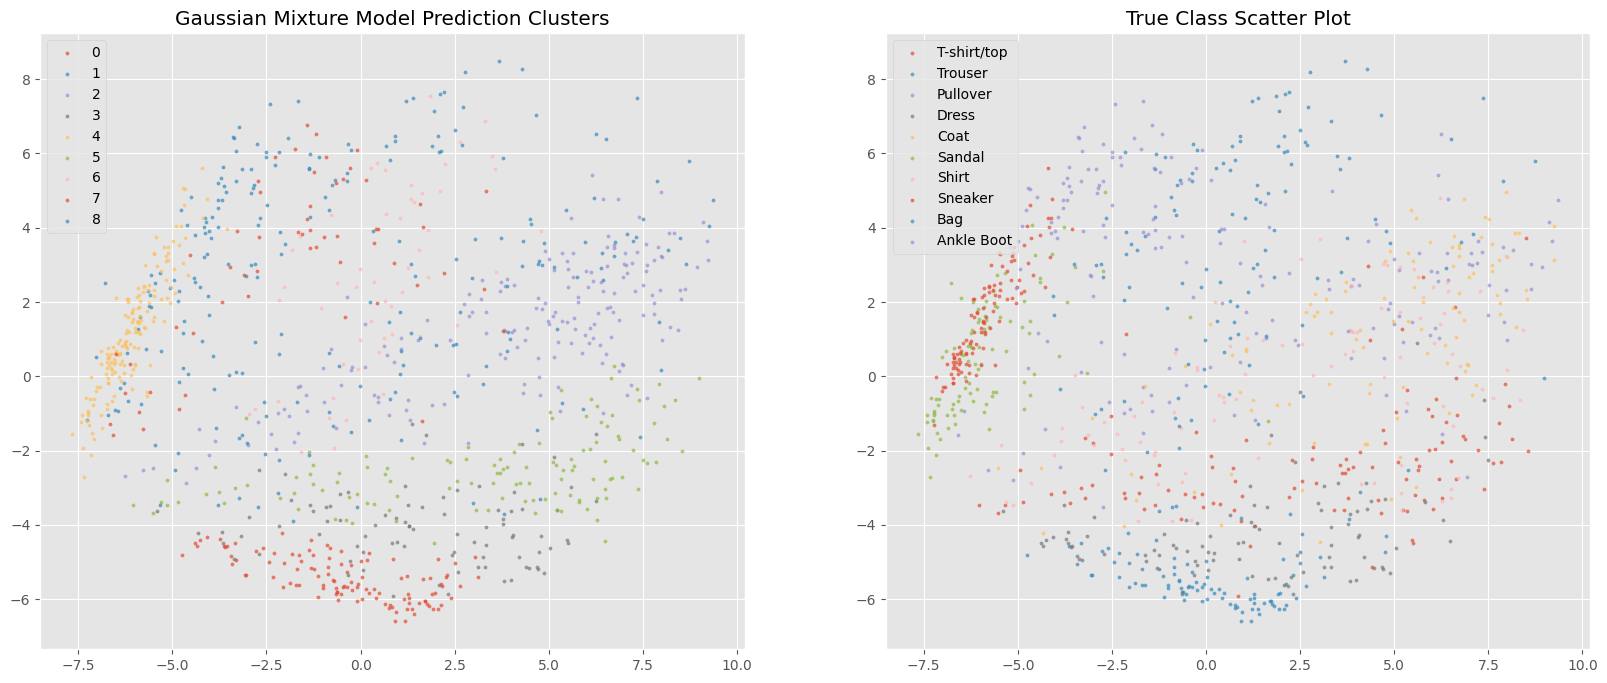

In [25]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(20,8)

for idx,y in enumerate(y_gmm_cols):
    # ax1 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.gmm_predicted_label==idx]
    sub_vals = sub_df.values
    ax1.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
ax1.legend()
ax1.set_title('Gaussian Mixture Model Prediction Clusters')

for idx,y in enumerate(y_cols):
    # ax2 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.label==idx]
    sub_vals = sub_df.values
    ax2.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
ax2.set_title('True Class Scatter Plot')
ax2.legend()
plt.show()

Cluster 0


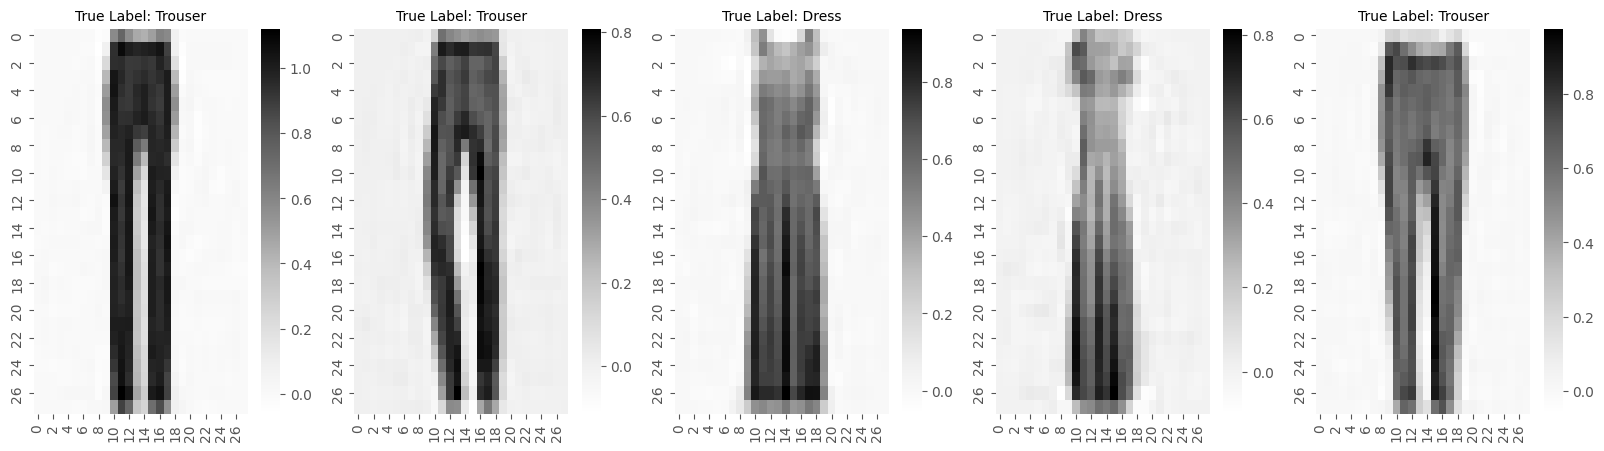

Cluster 1


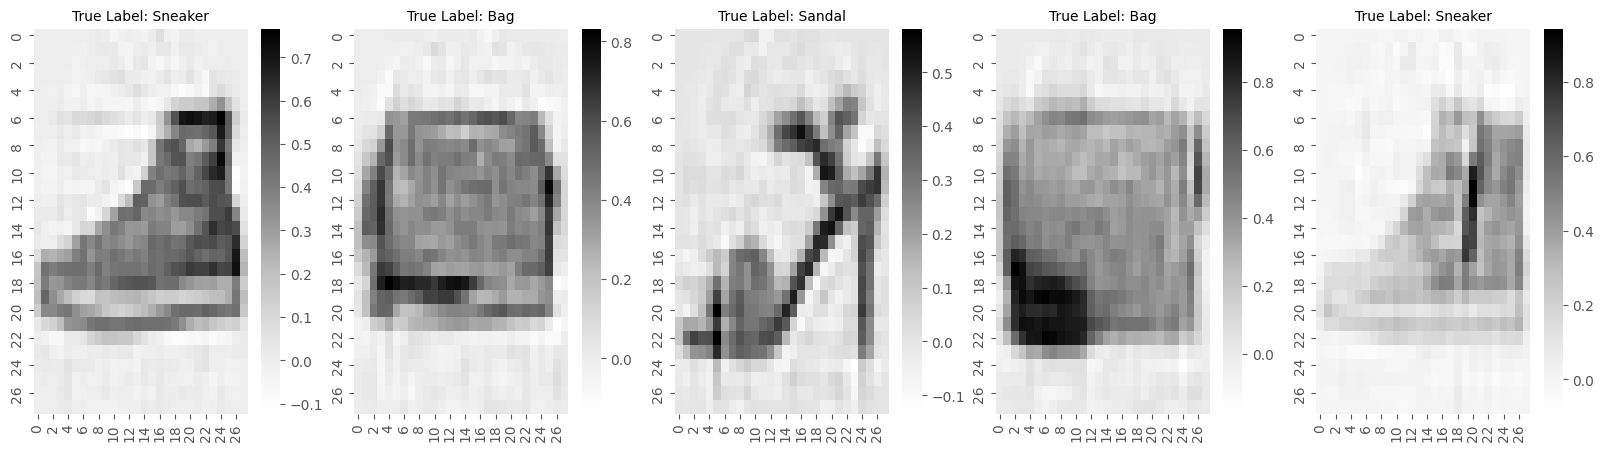

Cluster 2


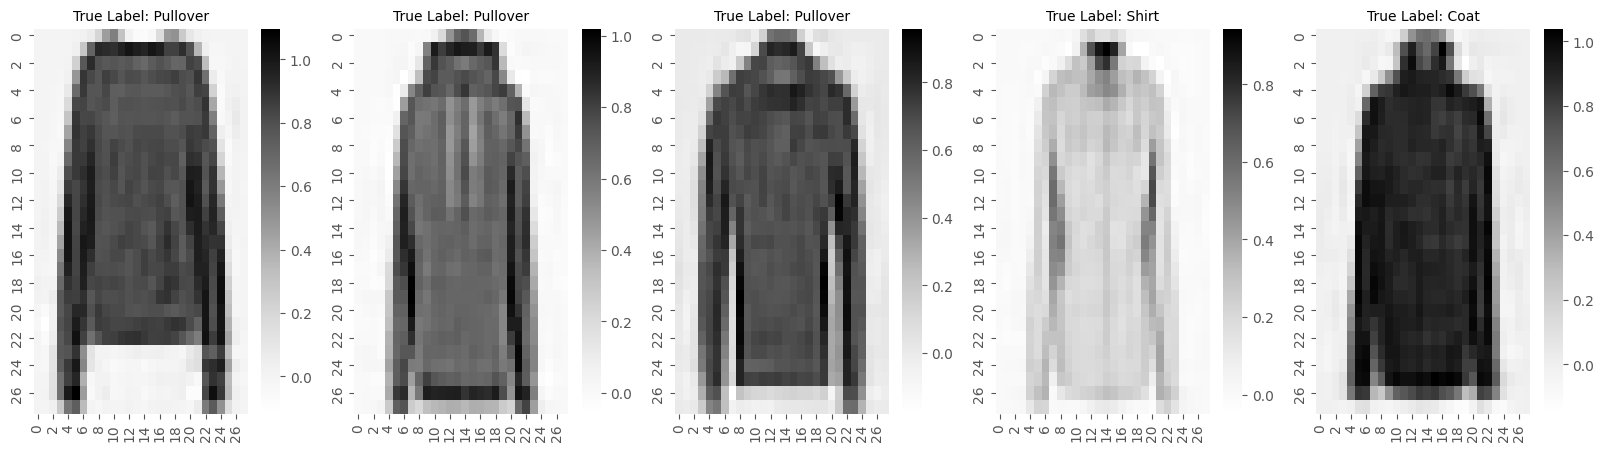

Cluster 3


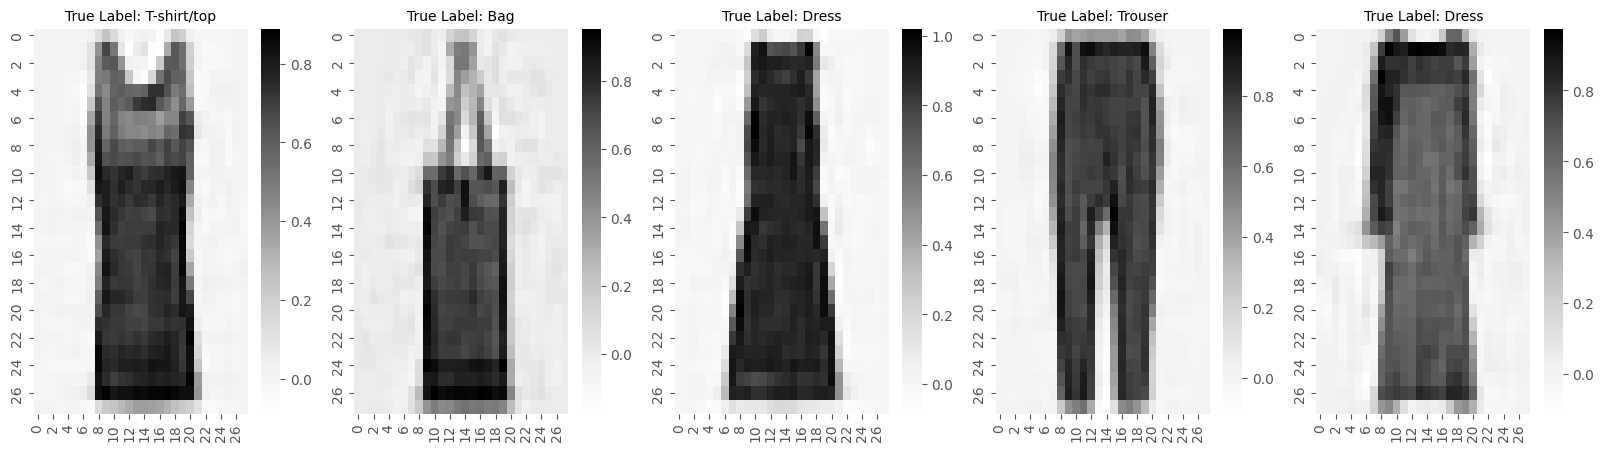

Cluster 4


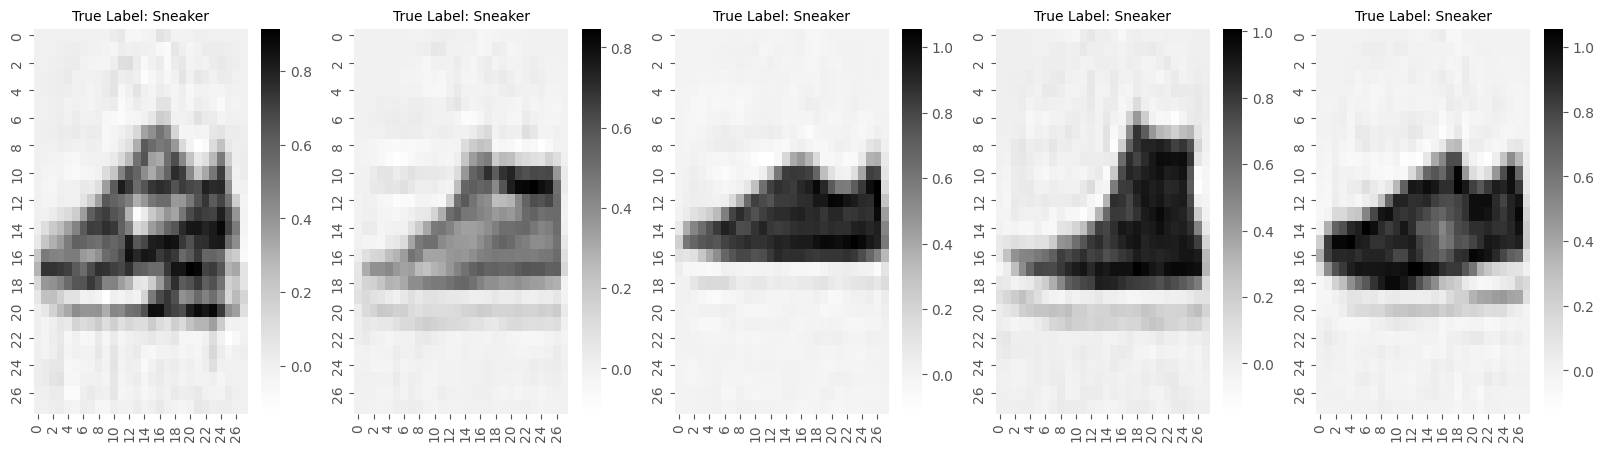

Cluster 5


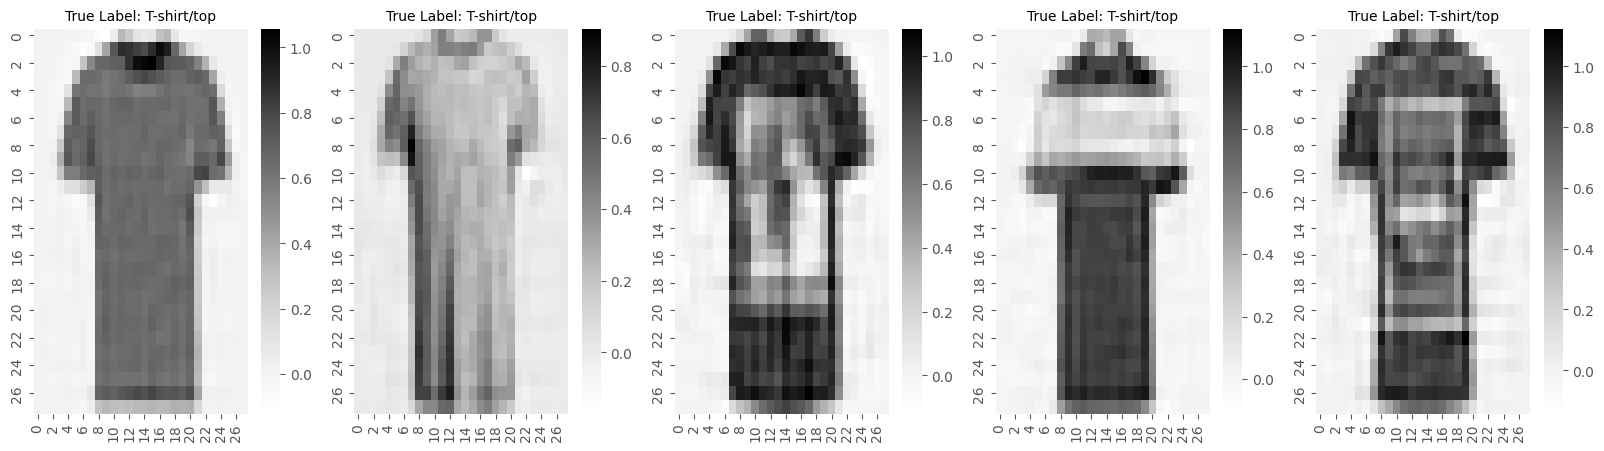

Cluster 6


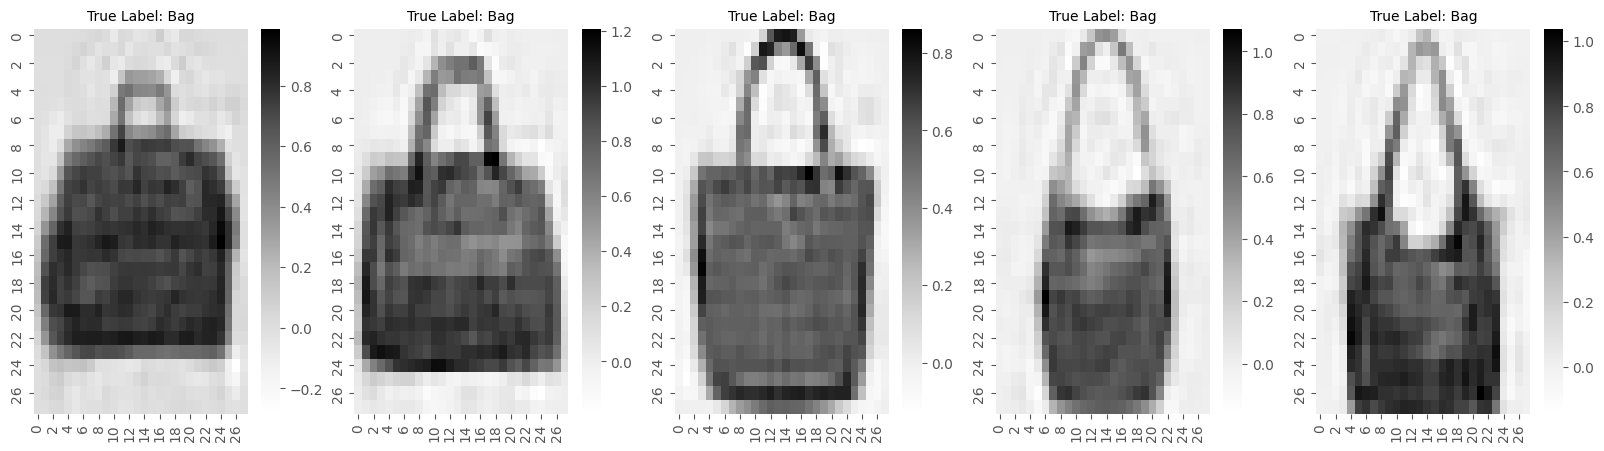

Cluster 7


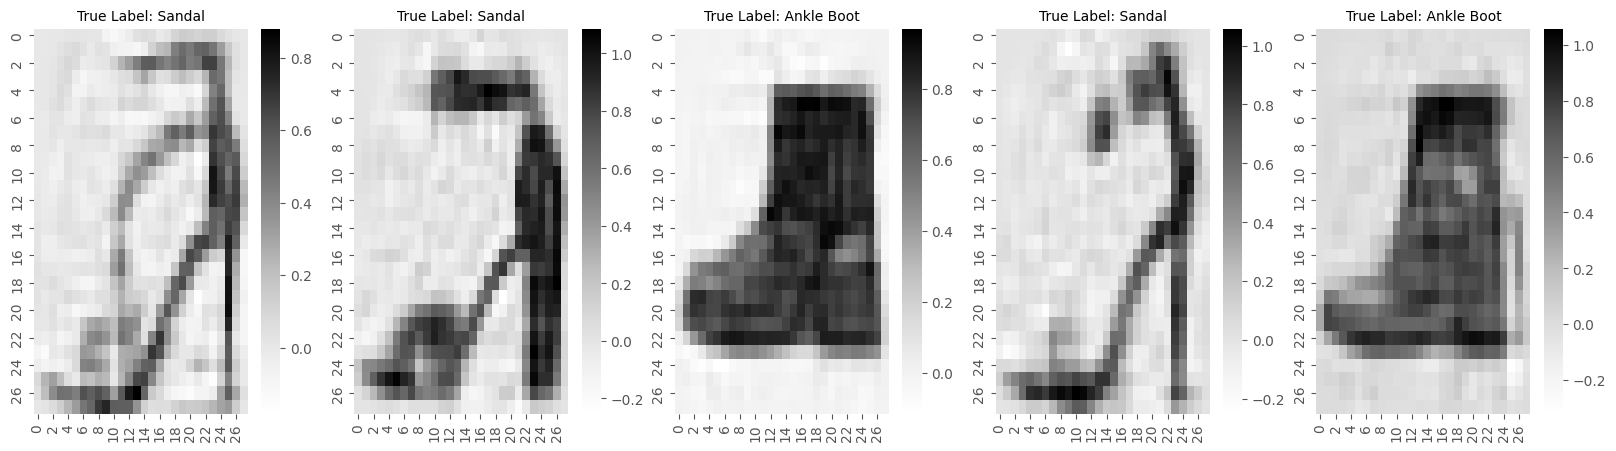

Cluster 8


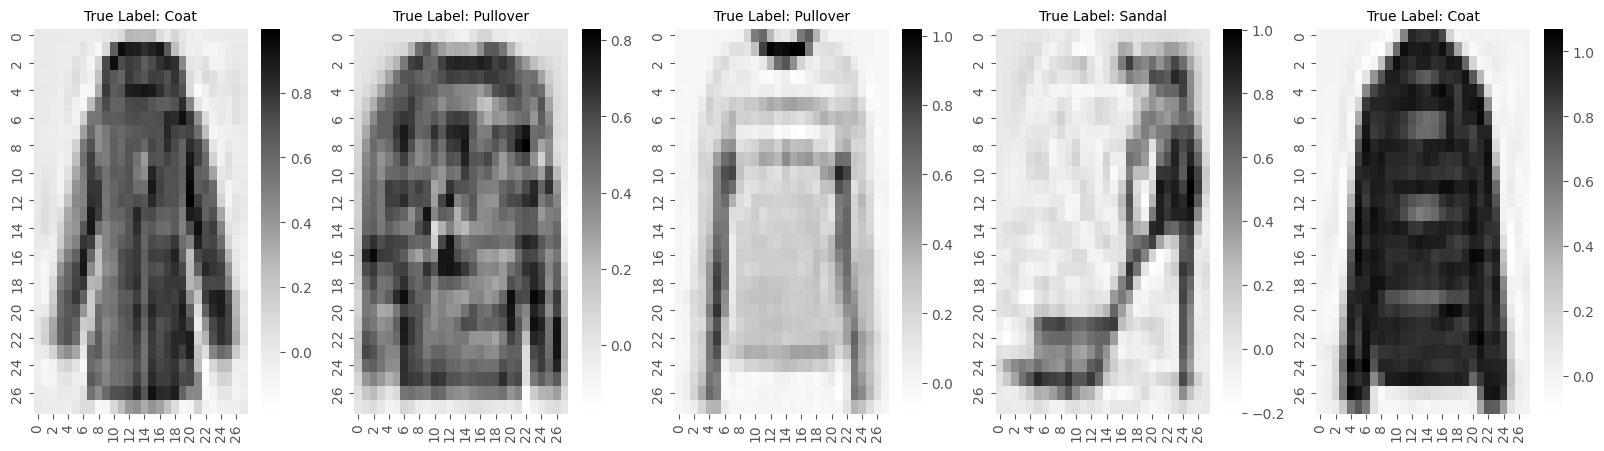

In [44]:
num_imgs = 5
for idx,y in enumerate(y_gmm_cols):
    # ax1 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.gmm_predicted_label==idx]
    sub_df = sub_df.sample(n=num_imgs)
    X_df = sub_df[sub_df.columns[:-2]].values
    X_df = pca_trans.inverse_transform(X_df)
    # print(X_df.shape)
    y_df = sub_df['label'].values
    fig,ax = plt.subplots(1,num_imgs,figsize=(20,5))
    print(f"Cluster {idx}")
    for i in range(num_imgs):
        sns.heatmap(X_df[i].reshape(28,28),cmap='Greys',ax=ax[i])
        ax[i].set_title(f"True Label: {y_cols[y_df[i]]}",fontsize=10)
    plt.show()

In the above intra-cluster images, we can see that similar clothing items are grouped together into 9 clusters. We have 10 class labels, but the GMM is able to combine two of the labels into a single cluster. 

## NEURAL NETWORKS IMPLEMENTATION

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [7]:
from IPython.display import clear_output
lrs = [0.1,0.001,0.00001]
lr_dict = {}
for lr in lrs:
    model = keras.Sequential([
    keras.layers.Dense(200, activation='ReLU'),
    keras.layers.Dense(50, activation='ReLU'),
    keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, validation_data=[X_val,y_val],verbose=1)
    lr_dict.update({str(lr):history})
    clear_output(wait=True)

Epoch 1/100
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4400 - accuracy: 0.5716 - val_loss: 0.9602 - val_accuracy: 0.7013
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8144 - accuracy: 0.7486 - val_loss: 0.7264 - val_accuracy: 0.7694
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6739 - accuracy: 0.7878 - val_loss: 0.6392 - val_accuracy: 0.7948
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6082 - accuracy: 0.8074 - val_loss: 0.5889 - val_accuracy: 0.8082
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5672 - accuracy: 0.8174 - val_loss: 0.5563 - val_accuracy: 0.8167
Epoch 6/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5386 - accuracy: 0.8256 - val_loss: 0.5332 - val_accuracy: 0.8239
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5172 - accuracy: 0.8305 - val_loss: 0.5136 - val_ac

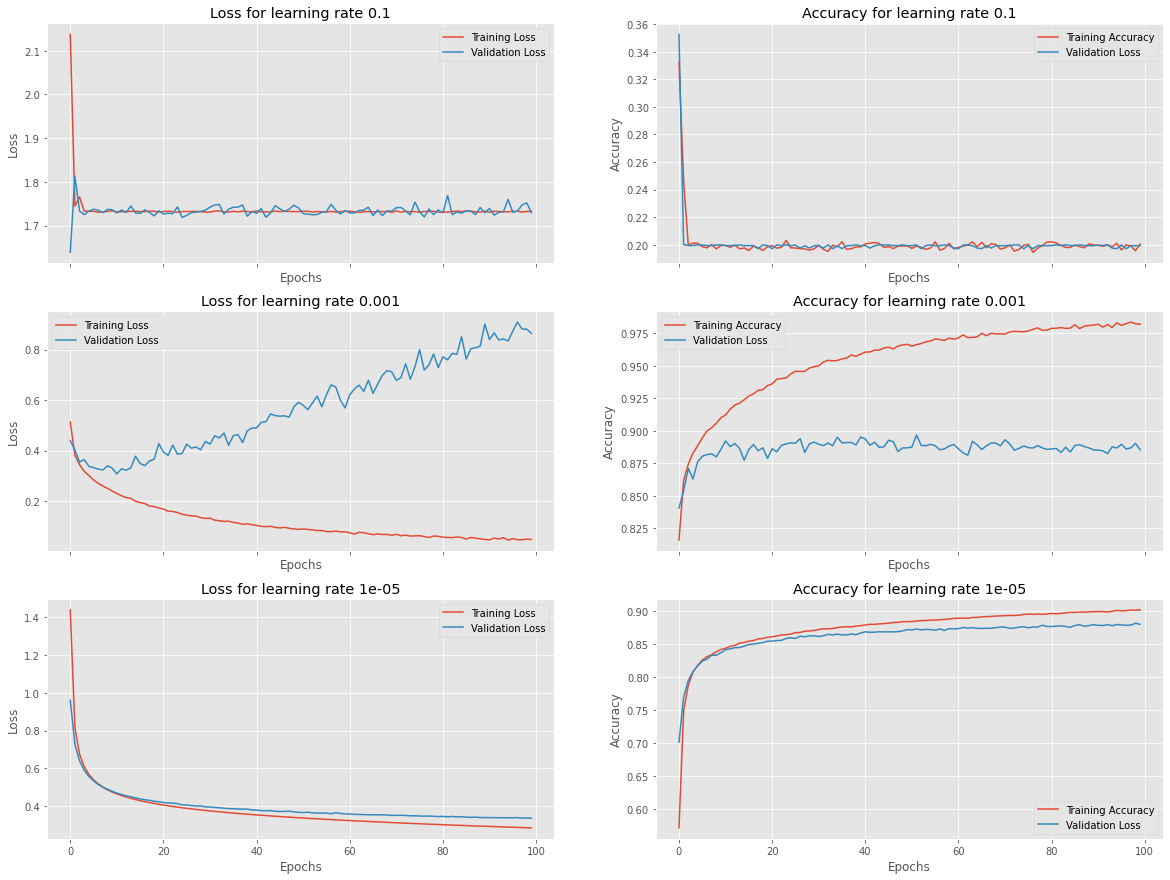

<Figure size 432x288 with 0 Axes>

In [18]:
plt.style.use('ggplot')
def plot_dictionary(lr_dict,save_name:str):
  dict_keys = [k for k in lr_dict.keys()]
  
  fig, axs = plt.subplots(3, 2,sharex=True)
  fig.set_size_inches(20,15)

  axs[0,0].plot(lr_dict[dict_keys[0]].history['loss'],label='Training Loss')
  axs[0,0].plot(lr_dict[dict_keys[0]].history['val_loss'],label='Validation Loss')
  axs[0,1].plot(lr_dict[dict_keys[0]].history['accuracy'],label='Training Accuracy')
  axs[0,1].plot(lr_dict[dict_keys[0]].history['val_accuracy'],label='Validation Loss')
  axs[0,0].set_title(f'Loss for learning rate {dict_keys[0]}')
  axs[0,1].set_title(f'Accuracy for learning rate {dict_keys[0]}')
  axs[0,0].set_xlabel('Epochs')
  axs[0,1].set_xlabel('Epochs')
  axs[0,0].set_ylabel('Loss')
  axs[0,1].set_ylabel('Accuracy')
  axs[0,0].legend()
  axs[0,1].legend()

  axs[1,0].plot(lr_dict[dict_keys[1]].history['loss'],label='Training Loss')
  axs[1,0].plot(lr_dict[dict_keys[1]].history['val_loss'],label='Validation Loss')
  axs[1,1].plot(lr_dict[dict_keys[1]].history['accuracy'],label='Training Accuracy')
  axs[1,1].plot(lr_dict[dict_keys[1]].history['val_accuracy'],label='Validation Loss')
  axs[1,0].set_title(f'Loss for learning rate {dict_keys[1]}')
  axs[1,1].set_title(f'Accuracy for learning rate {dict_keys[1]}')
  axs[1,0].set_xlabel('Epochs')
  axs[1,1].set_xlabel('Epochs')
  axs[1,0].set_ylabel('Loss')
  axs[1,1].set_ylabel('Accuracy')
  axs[1,0].legend()
  axs[1,1].legend()

  axs[2,0].plot(lr_dict[dict_keys[2]].history['loss'],label='Training Loss')
  axs[2,0].plot(lr_dict[dict_keys[2]].history['val_loss'],label='Validation Loss')
  axs[2,1].plot(lr_dict[dict_keys[2]].history['accuracy'],label='Training Accuracy')
  axs[2,1].plot(lr_dict[dict_keys[2]].history['val_accuracy'],label='Validation Loss')
  axs[2,0].set_title(f'Loss for learning rate {dict_keys[2]}')
  axs[2,1].set_title(f'Accuracy for learning rate {dict_keys[2]}')
  axs[2,0].set_xlabel('Epochs')
  axs[2,1].set_xlabel('Epochs')
  axs[2,0].set_ylabel('Loss')
  axs[2,1].set_ylabel('Accuracy')
  axs[2,0].legend()
  axs[2,1].legend()

  plt.show()
  plt.savefig(f'{save_name}.png')

plot_dictionary(lr_dict,'ReLU')

**Observation:**

The observations are for 3 different learning rates of 0.1,0.001, and 0.00001.
For lower learning rate of  0.00001 the model perfomed well and there is less gap between the training and validation loss,accuracy curves.The training and validation loss curves are decreasing and converging to a low value.

For learning rate of 0.001, there is a large gap between the traning and the validation loss curves.With the increase in the epochs the gap between the curves is increasing. The training loss is decreasing while the validation loss is increasing .The model has essentially memorized the training data and does not generalize well to new data.Hence model is Overfitting.

For high learning rate of 0.1, the gap between the train and the validation loss curves is very minimum even for the low epoch value.There is no change in the values of the curves with the increse in the epochs. Also the accuracy of the train and validation curves is very low at around 20%, and there is no change in value with change in epochs.The model converged early and has very low accuracy, the model might have converged at a local minimum.

In [19]:
from IPython.display import clear_output

lrs = [0.1,0.001,0.00001]
lr_dict_linear = {}
for lr in lrs:
    model_linear = keras.Sequential([
    keras.layers.Dense(200, activation='linear'),
    keras.layers.Dense(50, activation='linear'),
    keras.layers.Dense(10, activation='softmax')
        ])
    model_linear.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=['accuracy'])
    history = model_linear.fit(X_train, y_train, epochs=100, validation_data=[X_val,y_val],verbose=1)
    lr_dict_linear.update({str(lr):history})
    clear_output(wait=True)

Epoch 1/100
1563/1563 [==============================] - 8s 4ms/step - loss: 1.2041 - accuracy: 0.6185 - val_loss: 0.8281 - val_accuracy: 0.7193
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7354 - accuracy: 0.7569 - val_loss: 0.6767 - val_accuracy: 0.7735
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6366 - accuracy: 0.7894 - val_loss: 0.6115 - val_accuracy: 0.7937
Epoch 4/100
1563/1563 [==============================] - 5s 4ms/step - loss: 0.5862 - accuracy: 0.8038 - val_loss: 0.5736 - val_accuracy: 0.8041
Epoch 5/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8140 - val_loss: 0.5494 - val_accuracy: 0.8132
Epoch 6/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5332 - accuracy: 0.8209 - val_loss: 0.5311 - val_accuracy: 0.8173
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5170 - accuracy: 0.8255 - val_loss: 0.5178 - val_ac

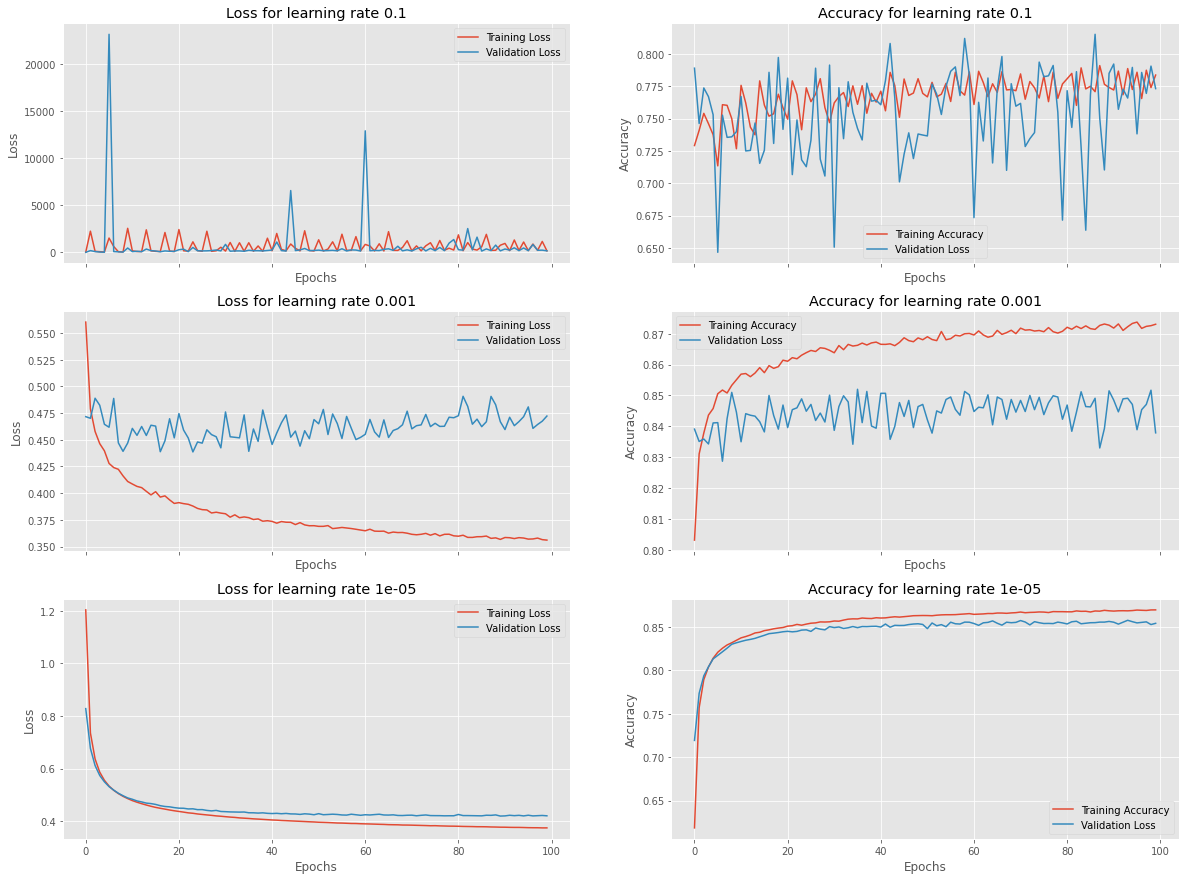

<Figure size 432x288 with 0 Axes>

In [20]:
plot_dictionary(lr_dict_linear,'Linear')

**Observation:**

The observations are for 3 different learning rates of 0.1,0.001, and 0.00001.
For lower learning rate of  0.00001 the model perfomed well and there is less gap between the training and validation loss,accuracy curves.The training and validation loss curves are decreasing and converging to a low value of loss.

For learning rate of 0.001, there is a gap between the traning and the validation loss curves.With the increase in the epochs the gap between the curves is increasing. The training loss is decreasing while the validation loss trend remain constant and value fluctuating between 0.43-0.47. The validation accuracy also fluctating between 83%-85% with increase in the epochs.It could indicate that the model is starting to overfit to the training data and is not able to generalize well to new data.It suggests that the model is improving its performance on the training data, but is not able to capture the underlying patterns in the data that would enable it to generalize well to new, unseen data. 

For high learning rate of 0.1, the training loss trend remained constant with minor fluctuation,but the validation loss curve is very erratic, the curve is having a lot of wide range fluctuations,this means the model is not converging .Due to high learning rate the model is not able to converge and reach global minimum. Also , the validation loss is decreasing and increasing drastically.



| Model           |  Accuracy Score  | Loss Score | 
| ----------------|---------------------|----------------------|
| ReLU Model     |    0.883              | 0.32        |
| Linear Model  | 0.86                |0.42                 |

So the ReLU model performed better than Linear model with lower loss and higher accuracy. Also, in most of plots above, RELU training was bit more stable as compared to linear. As FashionMNIST is a non-linear dataset, so linear activation is not a suitable activation function as compared to ReLU. 

In [23]:
model_relu = keras.Sequential([
    keras.layers.Dense(200, activation='ReLU'),
    keras.layers.Dense(50, activation='ReLU'),
    keras.layers.Dense(10, activation='softmax')
        ])
model_relu.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])
history = model_relu.fit(X_train, y_train, epochs=100, validation_data=[X_val,y_val],verbose=0)

In [24]:
model_relu.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.3246 - accuracy: 0.8833 - 581ms/epoch - 2ms/step


[0.32463547587394714, 0.8833000063896179]

In [25]:
model_linear = keras.Sequential([
    keras.layers.Dense(200, activation='linear'),
    keras.layers.Dense(50, activation='linear'),
    keras.layers.Dense(10, activation='softmax')
        ])
model_linear.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])
history = model_linear.fit(X_train, y_train, epochs=100, validation_data=[X_val,y_val],verbose=1)

In [26]:
model_linear.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.4165 - accuracy: 0.8599 - 594ms/epoch - 2ms/step


[0.41653895378112793, 0.8598999977111816]

In [27]:
print(model_relu.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 200)               157000    
                                                                 
 dense_28 (Dense)            (None, 50)                10050     
                                                                 
 dense_29 (Dense)            (None, 10)                510       
                                                                 
Total params: 167,560
Trainable params: 167,560
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
num_biases = model_relu.layers[0].get_weights()[1].shape[0] + model_relu.layers[1].get_weights()[1].shape[0] + model_relu.layers[2].get_weights()[1].shape[0]

print("Number of bias parameters = ",num_biases)

Number of bias parameters =  260


The network has a total of 167,560 parameters, out of which 260 are bias parameters.